In [15]:
import pyvista as pv
import numpy as np 
import os
import pandas as pd 
import pickle
import seaborn as sns
import scipy.stats as stats
import scipy.io as sio
import random as rd 
import pyvista as pv 
import matplotlib.pyplot as plt 
from scipy.spatial import distance
from nilearn.datasets import fetch_surf_fsaverage
from nilearn import surface

# Utils import
from utils.mathutils import compute_vertex_normals, build_template_adjacency_two_hemis, compute_mean_curvature, compute_curvature_differences, compute_hausdorff_metrics, compute_point_distances, compute_normal_differences
from utils.file_manip.Matlab_to_array import load_faces, load_vertices
from utils.cortical import surface_preprocess as sp
from utils.cortical import spherical_harmonics as SH
from utils.mathutils import cart_to_sph
from utils.file_manip.vtk_processing import convert_triangles_to_pyvista

In [11]:
data_path=r"C:\Users\wbou2\Desktop\meg_to_surface_ml\src\cortical_transformation\data"
main_folder = r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\Anatomy_data_CAM_CAN"
template_projection_lh = np.load(os.path.join(data_path, "lh_sphere_projection.npz"))
template_projection_rh = np.load(os.path.join(data_path, "rh_sphere_projection.npz"))


sub_name="sub-CC110033"
sub_file=os.path.join(main_folder, sub_name)

In [12]:
lmax = 80
sigma=1e-7
lambda_reg=1e-7
n_subjects=len(os.listdir(main_folder))
sns.set_theme(style="whitegrid")

In [13]:
# Load hemisphere-specific harmonics and slice according to lmax (limited to lmax<=80)
Y_lh_full = np.load(os.path.join(data_path, "Y_lh.npz"))['Y']
Y_rh_full = np.load(os.path.join(data_path, "Y_rh.npz"))['Y']

# Left hemisphere uses first part, right hemisphere uses second part
Y_lh = Y_lh_full[:, :(lmax+1)**2]
Y_rh = Y_rh_full[:, :(lmax+1)**2:]

In [ ]:
def register(surface, output_file):
    coords, tris = surface
    if not output_file.endswith(".npz"):
        output_file+=".npz"
    np.savez(output_file, coords=coords, tris=tris)   

In [ ]:
# Load fsaverage
fsaverage7 = fetch_surf_fsaverage(mesh='fsaverage7')
surf_lh = surface.load_surf_mesh(fsaverage7['pial_left'])
surf_rh = surface.load_surf_mesh(fsaverage7['pial_right'])

# Output file 
folder_output = r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\fsaverage"
os.makedirs(folder_output, exist_ok=True)

# Left Hemi
surface_mesh_lh = (surf_lh[0], surf_lh[1])
coords_lh, tris_lh = sp.get_resampled_inner_surface(surface_mesh_lh, 'lh')
center_lh = np.mean(coords_lh, axis=0)
coords_lh = coords_lh - center_lh
output_file_lh = os.path.join(folder_output, "lh_resampled.npz")
np.savez(output_file_lh, coords=coords_lh, tris=tris_lh, center=center_lh)

# Right hemi
surface_mesh_rh = (surf_rh[0], surf_rh[1])
coords_rh, tris_rh = sp.get_resampled_inner_surface(surface_mesh_rh, 'rh')
center_rh = np.mean(coords_rh, axis=0)
coords_rh = coords_rh - center_rh
output_file_rh = os.path.join(folder_output, "rh_resampled.npz")
np.savez(output_file_rh, coords=coords_rh, tris=tris_rh, center=center_rh)

In [ ]:
# Save resampled cortical surfaces
for folder in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder)
    if os.path.isdir(folder_path):
        print(f"Processing subject: {folder}")
        try:
            left_vertices_file = os.path.join(folder_path, "lh_vertices.mat")
            left_faces_file = os.path.join(folder_path, "lh_faces.mat")
            output_file = os.path.join(folder_path, "lh_resampled.npz")
            
            left_faces = load_faces(left_faces_file)
            left_vertices = load_vertices(left_vertices_file)
            coords, tris = sp.get_resampled_inner_surface((left_vertices, left_faces), 'lh')
            center = np.mean(coords, axis=0)
            coords = coords - center
            np.savez(output_file, coords=coords, tris=tris, center=center)
            print(f"  Left hemisphere processed successfully")

        except Exception as e:
            print(f"  Error processing left hemisphere: {str(e)}")
        
        try:
            right_vertices_file = os.path.join(folder_path, "rh_vertices.mat")
            right_faces_file = os.path.join(folder_path, "rh_faces.mat")
            output_file = os.path.join(folder_path, "rh_resampled.npz")
            
            right_faces = load_faces(right_faces_file)
            right_vertices = load_vertices(right_vertices_file)
            coords, tris = sp.get_resampled_inner_surface((right_vertices, right_faces), 'rh')
            center = np.mean(coords, axis=0)
            coords = coords - center
            np.savez(output_file, coords=coords, tris=tris, center=center)
            print(f"  Right hemisphere processed successfully")
        except Exception as e:
            print(f"  Error processing right hemisphere: {str(e)}")

In [46]:
fsaverage_path=r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\fsaverage"
# Load resampled data!
fsav_lh = np.load(os.path.join(fsaverage_path, "lh_resampled.npz"))
fsav_rh = np.load(os.path.join(fsaverage_path, "rh_resampled.npz"))

# Prepare resampled surfaces for coefficient computation
resampled_lh = (fsav_lh['coords'], fsav_lh['tris'])
resampled_rh = (fsav_rh['coords'], fsav_rh['tris'])

# Compute coefficients for both hemispheres
coeffs_fsav_lh = SH.compute_coefficients_SVD(Y_lh, resampled_lh, lmax, lambda_reg=lambda_reg)
coeffs_fsav_rh = SH.compute_coefficients_SVD(Y_rh, resampled_rh, lmax, lambda_reg=lambda_reg)

# Save coefficients
with open(os.path.join(fsaverage_path, "coeffs_lh.pkl"), 'wb') as f:
    pickle.dump(coeffs_fsav_lh, f)
with open(os.path.join(fsaverage_path, "coeffs_rh.pkl"), 'wb') as f:
    pickle.dump(coeffs_fsav_rh, f)

In [ ]:
# Save coefficients for each hemisphere of each subject
for folder in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder)
    if os.path.isdir(folder_path):
        coeffs_lh_path = os.path.join(folder_path, "coeffs_lh.pkl")
        coeffs_rh_path = os.path.join(folder_path, "coeffs_rh.pkl")
        
        # Load hemisphere-specific harmonics and slice according to lmax
        Y_lh_full = np.load(os.path.join(data_path, "Y_lh.npz"))['Y']
        Y_rh_full = np.load(os.path.join(data_path, "Y_rh.npz"))['Y']
        
        # Left hemisphere uses first part, right hemisphere uses second part
        Y_lh = Y_lh_full[:, :(lmax+1)**2]
        Y_rh = Y_rh_full[:, :(lmax+1)**2:]
        
        print(f"Processing left hemi of {folder}")
        left_resampled_data = np.load(os.path.join(folder_path, "lh_resampled.npz"))
        
        # Smooth the left hemisphere surface
        left_smoothed_coords = sp.smooth_surface(left_resampled_data['coords'], 
                                           left_resampled_data['tris'],
                                           n_iterations=5, 
                                           relaxation_factor=0.5)
        
        coeffs_lh = SH.compute_coefficients_SVD(Y_lh, 
                                              (left_smoothed_coords, left_resampled_data['tris']), 
                                              lmax, 
                                              lambda_reg)
        with open(coeffs_lh_path, 'wb') as f:
            pickle.dump(coeffs_lh, f)
        
        print(f"Processing right hemi of {folder}")
        right_resampled_data = np.load(os.path.join(folder_path, "rh_resampled.npz"))
        
        # Smooth the right hemisphere surface
        right_smoothed_coords = sp.smooth_surface(right_resampled_data['coords'], 
                                            right_resampled_data['tris'],
                                            n_iterations=5, 
                                            relaxation_factor=0.5)
        
        coeffs_rh = SH.compute_coefficients_SVD(Y_rh,
                                              (right_smoothed_coords, right_resampled_data['tris']),
                                              lmax, 
                                              lambda_reg)
        with open(coeffs_rh_path, 'wb') as f:
            pickle.dump(coeffs_rh, f)

In [31]:
import os
import numpy as np
import pickle
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
from utils.mathutils import (hausdorff_distance, compute_normal_differences,
                           compute_mean_curvature, build_template_adjacency_two_hemis,
                           compute_vertex_normals, compute_face_normals)
import matplotlib.pyplot as plt

# Structure de stockage pour les métriques
means_by_l = {
   'lh': {metric: [] for metric in ['hausdorff_norm', 'normal_errors', 'curvature_errors', 'high_angle_percent']},
   'rh': {metric: [] for metric in ['hausdorff_norm', 'normal_errors', 'curvature_errors', 'high_angle_percent']}
}

# Définir les valeurs de l
l_values = list(range(1, 50)) + list(range(50, lmax + 1, 2))

# Progress bar
pbar = tqdm(l_values, desc="Processing l values")

# Création vertex_to_faces une seule fois
vertex_to_faces = build_template_adjacency_two_hemis(template_tris_lh, template_tris_rh)

for l in pbar:
   current_l_metrics = {
       'lh': {metric: [] for metric in ['hausdorff_norm', 'normal_errors', 'curvature_errors', 'high_angle_percent']},
       'rh': {metric: [] for metric in ['hausdorff_norm', 'normal_errors', 'curvature_errors', 'high_angle_percent']}
   }
   
   # Truncate Y for this order
   Y_l = Y[:, :(l+1)**2]
   
   for folder in os.listdir(main_folder):
       folder_path = os.path.join(main_folder, folder)
       if not os.path.isdir(folder_path):
           continue
           
       try:
           for hemi in ['lh', 'rh']:
               # Charger les données
               with open(os.path.join(folder_path, f"coeffs_{hemi}.pkl"), 'rb') as f:
                   coeffs = pickle.load(f)
               org_coeffs = {i: coeffs['organized_coeffs'][i] for i in range(l+1)}
               resampled_data = np.load(os.path.join(folder_path, f"{hemi}_resampled.npz"))
               recon_surface = SH.generate_surface(Y_l, l, 0, org_coeffs)

               # Calcul de la taille caractéristique 
               char_size = np.max(np.ptp(resampled_data['coords'], axis=0))
               
               # Calcul des normales
               resampled_normals = compute_vertex_normals(resampled_data['coords'], 
                                                        resampled_data['tris'], 
                                                        vertex_to_faces)
               recon_normals = compute_vertex_normals(recon_surface, 
                                                    resampled_data['tris'], 
                                                    vertex_to_faces)
               
               # Calcul des courbures
               resampled_curv = compute_mean_curvature(resampled_data['coords'], 
                                                     resampled_data['tris'], 
                                                     vertex_to_faces)
               recon_curv = compute_mean_curvature(recon_surface, 
                                                 resampled_data['tris'], 
                                                 vertex_to_faces)
               
               # Calcul des métriques
               hausdorff = hausdorff_distance(resampled_data['coords'], recon_surface) 
               hausdorff_norm = hausdorff / char_size
               normal_diff = compute_normal_differences(resampled_normals, recon_normals)
               
               # Stockage des métriques
               current_l_metrics[hemi]['hausdorff_norm'].append(hausdorff_norm)
               current_l_metrics[hemi]['normal_errors'].append(normal_diff['mean_angle'])
               current_l_metrics[hemi]['high_angle_percent'].append(normal_diff['percent_large_errors'])
               current_l_metrics[hemi]['curvature_errors'].append(
                   np.mean(np.abs(resampled_curv - recon_curv))
               )
               
       except Exception as e:
           print(f"Erreur pour {folder} à l'ordre {l}: {str(e)}")
           continue
   
   # Calcul des moyennes pour cet ordre l
   for hemi in ['lh', 'rh']:
       for metric in means_by_l[hemi].keys():
           if current_l_metrics[hemi][metric]:
               means_by_l[hemi][metric].append(np.mean(current_l_metrics[hemi][metric]))
           else:
               means_by_l[hemi][metric].append(np.nan)
   
   # Sauvegarde intermédiaire tous les 10 l
   if l % 10 == 0:
       with open(f'metrics_backup_l_{l}.pkl', 'wb') as f:
           pickle.dump(means_by_l, f)

# Plot des résultats
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

metrics = ['hausdorff_norm', 'normal_errors', 'curvature_errors', 'high_angle_percent']
titles = ['Normalized Hausdorff Distance', 'Mean Normal Angle Error (degrees)', 
         'Mean Curvature Error', 'Percentage of Normal Errors > 45°']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
   for hemi in ['lh', 'rh']:
       axes[idx].plot(l_values, means_by_l[hemi][metric], 
                    label=f'{hemi.upper()}', 
                    marker='o', markersize=2)
   axes[idx].set_xlabel('l-value')
   axes[idx].set_ylabel(title)
   axes[idx].set_xscale('log')
   axes[idx].grid(True)
   axes[idx].legend()

plt.tight_layout()
plt.show()

# Sauvegarde finale
with open('final_metrics.pkl', 'wb') as f:
   pickle.dump({'metrics': means_by_l, 'l_values': l_values}, f)

ImportError: cannot import name 'compute_normal_differences' from 'utils.mathutils' (c:\users\wbou2\desktop\meg_to_surface_ml\utils\mathutils.py)

Analysis of the error across subjects (mean over subject)

In [75]:
def mean_reconstruction(l, main_folder, output_path):
    first_path = os.path.join(main_folder, os.listdir(main_folder)[0])
    tris = np.load(os.path.join(first_path, "lh_resampled.npz"))['tris']
    mean_coords_lh = np.zeros(shape=(40962, 3))
    mean_coords_rh = np.zeros(shape=(40962, 3))
    n_subjects = len([f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))])
    
    for folder in os.listdir(main_folder):
        folder_path = os.path.join(main_folder, folder)
        if os.path.isdir(folder_path):
            Y_l = Y[:, :(l+1)**2]
            
            # Left hemisphere
            with open(os.path.join(folder_path, "coeffs_lh.pkl"), 'rb') as f:
                coeffs_lh = pickle.load(f)
            org_coeffs_lh = {i: coeffs_lh['organized_coeffs'][i] for i in range(l+1)}
            mean_coords_lh += SH.generate_surface(Y_l, l, 0, org_coeffs_lh)

            # Right hemisphere
            with open(os.path.join(folder_path, "coeffs_rh.pkl"), 'rb') as f:
                coeffs_rh = pickle.load(f)
            org_coeffs_rh = {i: coeffs_rh['organized_coeffs'][i] for i in range(l+1)}
            mean_coords_rh += SH.generate_surface(Y_l, l, 0, org_coeffs_rh)
    
    mean_coords_lh /= n_subjects
    mean_coords_rh /= n_subjects
    
    # Save results
    os.makedirs(output_path, exist_ok=True)
    np.savez(os.path.join(output_path, f'mean_brain_l{l}.npz'),
             coords_lh=mean_coords_lh,
             coords_rh=mean_coords_rh,
             tris=tris)
            

In [14]:
l=30
first_path = os.path.join(main_folder, os.listdir(main_folder)[0])
tris = np.load(os.path.join(first_path, "lh_resampled.npz"))['tris']
n_subjects = len([f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))])

for folder in os.listdir(main_folder):
   folder_path = os.path.join(main_folder, folder)
   if os.path.isdir(folder_path):
       # Load centers from npz files
       lh_data = np.load(os.path.join(folder_path, "lh_resampled.npz"))
       rh_data = np.load(os.path.join(folder_path, "rh_resampled.npz"))
       lh_center = lh_data['center']
       rh_center = rh_data['center']

       # Left hemisphere processing
       Y_l = Y_lh_full[:, :(l+1)**2]
       with open(os.path.join(folder_path, "coeffs_lh.pkl"), 'rb') as f:
           coeffs_lh = pickle.load(f)
       org_coeffs_lh = {i: coeffs_lh['organized_coeffs'][i] for i in range(l+1)}
       coords_lh = SH.generate_surface(Y_l, l, 0, org_coeffs_lh)

       # Right hemisphere processing
       Y_r = Y_rh_full[:, :(l+1)**2]
       with open(os.path.join(folder_path, "coeffs_rh.pkl"), 'rb') as f:
           coeffs_rh = pickle.load(f)
       org_coeffs_rh = {i: coeffs_rh['organized_coeffs'][i] for i in range(l+1)}
       coords_rh = SH.generate_surface(Y_r, l, 0, org_coeffs_rh)

       # Add centers back and merge
       lh_reconstruction = coords_lh + lh_center
       rh_reconstruction = coords_rh + rh_center
       reconstructed_merged_coords, reconstructed_merged_tris = sp.merge_hemis(
           (lh_reconstruction, tris),
           (rh_reconstruction, tris)
       )
       

       np.savez(os.path.join(folder_path, "brain_reconstructed.npz"), 
               coords=reconstructed_merged_coords, 
               tris=reconstructed_merged_tris)
  

In [16]:
for folder in os.listdir(main_folder):
   folder_path = os.path.join(main_folder, folder)
   if os.path.isdir(folder_path):
       # Load npz file
       data = np.load(os.path.join(folder_path, "brain_reconstructed.npz"))
       
       # Create TessMat structure for MATLAB
       TessMat = {
           'Vertices': data['coords'],
           'Faces': data['tris'] + 1  # +1 as MATLAB indexing starts at 1
       }
       
       # Save to MATLAB format
       sio.savemat(os.path.join(folder_path, 'brain_reconstructed.mat'), {'TessMat': TessMat})

In [ ]:
def collect_error_distributions(l, main_folder, Y):
    collected_data = {
        'lh': {
            'raw_distributions': {
                'point_errors': [],    
                'distance_errors': [], 
                'angle_errors': [],    
                'area_errors': []      
            },
            'normalization_factors': []
        },
        'rh': {
            'raw_distributions': {
                'point_errors': [],
                'distance_errors': [],
                'angle_errors': [],
                'area_errors': []
            },
            'normalization_factors': []
        }
    }
    
    Y_l = Y[:, :(l+1)**2]
    
    for folder in os.listdir(main_folder):
        folder_path = os.path.join(main_folder, folder)
        if os.path.isdir(folder_path):
            # Left hemisphere
            with open(os.path.join(folder_path, "coeffs_lh.pkl"), 'rb') as f:
                coeffs_lh = pickle.load(f)
            org_coeffs_lh = {i: coeffs_lh['organized_coeffs'][i] for i in range(l+1)}
            resampled_data_lh = np.load(os.path.join(folder_path, "lh_resampled.npz"))
            recon_surface_lh = SH.generate_surface(Y_l, l, 0, org_coeffs_lh)
            
            orig_metrics_lh = compute_raw_surface_metrics(resampled_data_lh['coords'], resampled_data_lh['tris'])
            recon_metrics_lh = compute_raw_surface_metrics(recon_surface_lh, resampled_data_lh['tris'])
            comparison_lh = compare_surface_metrics(orig_metrics_lh, recon_metrics_lh)
            
            for metric in collected_data['lh']['raw_distributions'].keys():
                collected_data['lh']['raw_distributions'][metric].append(comparison_lh['raw_distributions'][metric])
            collected_data['lh']['normalization_factors'].append(comparison_lh['normalization_factors'])
            
            # Right hemisphere
            with open(os.path.join(folder_path, "coeffs_rh.pkl"), 'rb') as f:
                coeffs_rh = pickle.load(f)
            org_coeffs_rh = {i: coeffs_rh['organized_coeffs'][i] for i in range(l+1)}
            resampled_data_rh = np.load(os.path.join(folder_path, "rh_resampled.npz"))
            recon_surface_rh = SH.generate_surface(Y_l, l, 0, org_coeffs_rh)
            
            orig_metrics_rh = compute_raw_surface_metrics(resampled_data_rh['coords'], resampled_data_rh['tris'])
            recon_metrics_rh = compute_raw_surface_metrics(recon_surface_rh, resampled_data_rh['tris'])
            comparison_rh = compare_surface_metrics(orig_metrics_rh, recon_metrics_rh)
            
            for metric in collected_data['rh']['raw_distributions'].keys():
                collected_data['rh']['raw_distributions'][metric].append(comparison_rh['raw_distributions'][metric])
            collected_data['rh']['normalization_factors'].append(comparison_rh['normalization_factors'])
    
    # Save all data in a single file
    filename = f'raw_error_distributions_l{l}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(collected_data, f)

In [ ]:
for l in orders:
    collect_error_distributions(l, main_folder, Y)

In [ ]:
def get_unique_pairs(data):
    flattened_data = []
    for v in range(data.shape[0]):
        vertex_data = data[v]
        for i in range(vertex_data.shape[0]):
            for j in range(i+1, vertex_data.shape[0]):
                flattened_data.extend([vertex_data[i], vertex_data[j]])
    return np.array(flattened_data)

def plot_error_distribution(raw_data, norm_data, z_scores, title, color, hemi):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
    
    ax1.hist(raw_data, bins=50, color=color, alpha=0.5, label=f'{hemi.upper()}')
    ax1.set_title(f'{title} (Raw/Characteristic Size)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    sns.kdeplot(data=norm_data, ax=ax2, color=color, alpha=0.5, fill=True, label=f'{hemi.upper()}')
    ax2.set_title(f'{title} (Normalized)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    sns.kdeplot(data=z_scores, ax=ax3, color=color, alpha=0.5, fill=True, label=f'{hemi.upper()}')
    ax3.set_title(f'{title} (Z-scores)')
    ax3.axvline(x=2, color='red', linestyle='--', alpha=0.5)
    ax3.axvline(x=-2, color='red', linestyle='--', alpha=0.5)
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    plt.show()

def analyze_all_metrics(l):
    with open(f'raw_error_distributions_l{l}.pkl', 'rb') as f:
        data = pickle.load(f)
    
    for hemi in ['lh', 'rh']:
        raw_dist = data[hemi]['raw_distributions']
        norm_factors = data[hemi]['normalization_factors']
        color = '#2E86C1' if hemi=='lh' else '#E74C3C'
        
        # Point Errors
        if 'point_errors' in raw_dist:
            raw = np.array(raw_dist['point_errors'])
            raw_norm_char = np.array([raw[i] / norm_factors[i]['characteristic_size'] for i in range(len(norm_factors))])
            raw_norm_char_mean = np.mean(raw_norm_char, axis=0)
            
            norm = np.array([raw[i] / norm_factors[i]['characteristic_size'] for i in range(len(norm_factors))])
            norm_mean = np.mean(norm, axis=0)
            
            z_scores = (norm_mean - np.mean(norm_mean)) / np.std(norm_mean)
            
            plot_error_distribution(raw_norm_char_mean, norm_mean, z_scores, 
                                 f'Point Errors (l={l})', color, hemi)
        
        # Area Errors
        if 'area_errors' in raw_dist:
            raw = np.array(raw_dist['area_errors'])
            raw_norm_char = np.array([raw[i] / norm_factors[i]['total_area'] for i in range(len(norm_factors))])
            raw_norm_char_mean = np.mean(raw_norm_char, axis=0)
            
            norm = np.array([raw[i] / norm_factors[i]['total_area'] for i in range(len(norm_factors))])
            norm_mean = np.mean(norm, axis=0)
            
            z_scores = (norm_mean - np.mean(norm_mean)) / np.std(norm_mean)
            
            plot_error_distribution(raw_norm_char_mean.flatten(), norm_mean.flatten(), z_scores.flatten(), 
                                 f'Area Errors (l={l})', color, hemi)
        
        # Distance Errors
        if 'distance_errors' in raw_dist:
            raw = np.array(raw_dist['distance_errors'])
            raw_norm_char = np.array([raw[i] / norm_factors[i]['mean_geodesic'] for i in range(len(norm_factors))])
            raw_norm_char_mean = np.mean(raw_norm_char, axis=0)
            
            norm = np.array([raw[i] / norm_factors[i]['mean_geodesic'] for i in range(len(norm_factors))])
            norm_mean = np.mean(norm, axis=0)
            
            z_scores = (norm_mean - np.mean(norm_mean)) / np.std(norm_mean)
            
            flat_raw = get_unique_pairs(raw_norm_char_mean)
            flat_norm = get_unique_pairs(norm_mean)
            flat_z = get_unique_pairs(z_scores)
            
            plot_error_distribution(flat_raw, flat_norm, flat_z,
                                 f'Distance Errors (l={l})', color, hemi)
        
        # Angle Errors
        if 'angle_errors' in raw_dist:
            raw = np.array(raw_dist['angle_errors'])
            raw_norm_char = np.array([raw[i] / norm_factors[i]['pi'] for i in range(len(norm_factors))])
            raw_norm_char_mean = np.mean(raw_norm_char, axis=0)
            
            norm = np.array([raw[i] / norm_factors[i]['pi'] for i in range(len(norm_factors))])
            norm_mean = np.mean(norm, axis=0)
            
            z_scores = (norm_mean - np.mean(norm_mean)) / np.std(norm_mean)
            
            flat_raw = get_unique_pairs(raw_norm_char_mean)
            flat_norm = get_unique_pairs(norm_mean)
            flat_z = get_unique_pairs(z_scores)
            
            plot_error_distribution(flat_raw, flat_norm, flat_z,
                                 f'Angle Errors (l={l})', color, hemi)

print("Starting analysis...")
for l in orders:
    try:
        analyze_all_metrics(l)
        print(f"Completed analysis for l={l}")
    except Exception as e:
        print(f"Failed to process l={l}: {str(e)}")
print("Analysis completed")

Visualization of the errors (to see what are the outliers)

In [79]:
def visualize_outliers_metrics(l, mean_brain_path, error_data_path, threshold=2):
    mean_data = np.load(mean_brain_path)
    with open(error_data_path, 'rb') as f:
        error_data = pickle.load(f)
    
    metrics = {
        'point_errors': 'characteristic_size',
        'area_errors': 'total_area',
        'distance_errors': 'mean_geodesic',
        'angle_errors': 'pi'
    }

    plotter = pv.Plotter(shape=(4, 2))  # 4 metrics x 2 hemispheres
    
    for idx, (metric_name, norm_factor_key) in enumerate(metrics.items()):
        for j, hemi in enumerate(['lh', 'rh']):
            plotter.subplot(idx, j)
            
            coords = mean_data[f'coords_{hemi}']
            tris = mean_data['tris']
            raw = np.array(error_data[hemi]['raw_distributions'][metric_name])
            norm_factors = error_data[hemi]['normalization_factors']
            
            norm = np.array([raw[i] / norm_factors[i][norm_factor_key] for i in range(len(norm_factors))])
            norm_mean = np.mean(norm, axis=0)
            z_scores = (norm_mean - np.mean(norm_mean)) / np.std(norm_mean)
            
            mesh = pv.PolyData(coords, np.hstack([np.full((len(tris), 1), 3), tris]))
            mesh.point_data['outliers'] = (np.abs(z_scores) > threshold).astype(int)
            
            plotter.add_mesh(mesh, scalars='outliers', cmap=['gray', 'red'])
            plotter.view_xy()
            plotter.add_text(f'{metric_name} - {hemi}')
    plotter.link_views()
    plotter.show()

In [93]:
visualize_outliers_metrics(50, 'mean_brain_l50.npz', 'raw_error_distributions_l50.pkl')

Widget(value='<iframe src="http://localhost:3497/index.html?ui=P_0x1cf15105e20_13&reconnect=auto" class="pyvis…

Study on the properties of the coefficients

In [5]:
coeffs_all_lh = {}
coeffs_all_rh = {}
for folder in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder)
    if os.path.isdir(folder_path):
        with open(os.path.join(folder_path, "coeffs_lh.pkl"), 'rb') as f:
            coeffs_lh = pickle.load(f)
        coeffs_all_lh[folder] =  coeffs_lh["organized_coeffs"]
        with open(os.path.join(folder_path, "coeffs_rh.pkl"), 'rb') as f:
            coeffs_rh = pickle.load(f)
        coeffs_all_rh[folder] =  coeffs_rh["organized_coeffs"]

# Load Fsaverage coeffs and surface

fsaverage_path = r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\fsaverage"
with open(os.path.join(fsaverage_path, "coeffs_lh.pkl"), 'rb') as f:
    coeffs_fsav_lh = pickle.load(f)['organized_coeffs']
fsav_data_lh = np.load(os.path.join(fsaverage_path, "lh_resampled.npz"))
coords_fsav_lh = fsav_data_lh['coords']
tris_fsav_lh = fsav_data_lh['tris']



with open(os.path.join(fsaverage_path, "coeffs_rh.pkl"), 'rb') as f:
    coeffs_fsav_rh = pickle.load(f)['organized_coeffs']
fsav_data_rh = np.load(os.path.join(fsaverage_path, "rh_resampled.npz"))
coords_fsav_rh = fsav_data_rh['coords']
tris_fsav_rh = fsav_data_rh['tris']

In [6]:
# Load Fsaverage coeffs and surface

fsaverage_path = r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\fsaverage"
with open(os.path.join(fsaverage_path, "coeffs_lh.pkl"), 'rb') as f:
    coeffs_fsav_lh = pickle.load(f)['organized_coeffs']
fsav_data_lh = np.load(os.path.join(fsaverage_path, "lh_resampled.npz"))
coords_fsav_lh = fsav_data_lh['coords']
tris_fsav_lh = fsav_data_lh['tris']



with open(os.path.join(fsaverage_path, "coeffs_rh.pkl"), 'rb') as f:
    coeffs_fsav_rh = pickle.load(f)['organized_coeffs']
fsav_data_rh = np.load(os.path.join(fsaverage_path, "rh_resampled.npz"))
coords_fsav_rh = fsav_data_rh['coords']
tris_fsav_rh = fsav_data_rh['tris']

In [7]:
# Création des dictionnaires pour stocker les différences
coeffs_diff_lh = {}
coeffs_diff_rh = {}

# Pour chaque sujet
for subject in coeffs_all_lh.keys():
    coeffs_diff_lh[subject] = {}
    coeffs_diff_rh[subject] = {}
    
    # Pour chaque l
    for l in range(len(coeffs_all_lh[subject])):
        coeffs_diff_lh[subject][l] = {}
        coeffs_diff_rh[subject][l] = {}
        
        # Pour chaque m, en utilisant la vraie plage de -l à +l
        for m_idx, m in enumerate(range(-l, l+1)):
            coeffs_diff_lh[subject][l][m] = coeffs_all_lh[subject][l][m_idx] - coeffs_fsav_lh[l][m_idx]
            coeffs_diff_rh[subject][l][m] = coeffs_all_rh[subject][l][m_idx] - coeffs_fsav_rh[l][m_idx]

In [28]:
subject_coeffs_lh=coeffs_all_lh[sub_name]
subject_coeffs_rh=coeffs_all_rh[sub_name]

In [12]:
def analyze_complex_coeffs(coeffs_all, l_value):
   # Extraction des coefficients
   coeffs_x, coeffs_y, coeffs_z = [], [], []
   
   for subject in coeffs_all:
       for m in range(-l_value, l_value + 1):
           vector = coeffs_all[subject][l_value][m]
           coeffs_x.append(vector[0])
           coeffs_y.append(vector[1])
           coeffs_z.append(vector[2])
   
   coeffs_x = np.array(coeffs_x)
   coeffs_y = np.array(coeffs_y)
   coeffs_z = np.array(coeffs_z)
   
   def rayleigh_test(phases):
       n = len(phases)
       R = np.sqrt((np.sum(np.cos(phases)))**2 + (np.sum(np.sin(phases)))**2)
       Z = R**2 / n
       p_value = np.exp(-Z)
       return Z, p_value

   def circular_mean(angles):
       return np.angle(np.mean(np.exp(1j * angles)))
   
   def circular_std(angles):
       R = np.abs(np.mean(np.exp(1j * angles)))
       return np.sqrt(-2 * np.log(R))
   
   fig = plt.figure(figsize=(15, 12))
   components = [
       (coeffs_x, 'X', 'red'),
       (coeffs_y, 'Y', 'green'),
       (coeffs_z, 'Z', 'blue')
   ]
   results = []
   
   for i, (coeffs, comp_name, color) in enumerate(components):
       phases = np.angle(coeffs)
       mean_phase = circular_mean(phases)
       std_phase = circular_std(phases)
       stat, p_val = rayleigh_test(phases)
       
       results.append({
           'component': comp_name,
           'rayleigh_stat': stat,
           'p_value': p_val,
           'mean_phase': mean_phase, 
           'std_phase': std_phase
       })
       
       # Plan complexe
       ax1 = plt.subplot(3, 3, 3 * i + 1)
       ax1.scatter(coeffs.real, coeffs.imag, alpha=0.5, color=color, s=1)
       ax1.axhline(0, color='gray', linestyle='--', linewidth=0.5)
       ax1.axvline(0, color='gray', linestyle='--', linewidth=0.5)
       ax1.set_title(f'{comp_name}-component: Complex Plane')
       ax1.set_xlabel('Re')
       ax1.set_ylabel('Im')
       ax1.grid(True)
       
       # Magnitudes
       ax2 = plt.subplot(3, 3, 3 * i + 2)
       magnitudes = np.abs(coeffs)
       ax2.hist(magnitudes, bins=30, density=True, alpha=0.7, color=color)
       ax2.set_title(f'{comp_name}-component: Magnitude Distribution')
       ax2.set_xlabel('Magnitude')
       
       # Phases
       ax3 = plt.subplot(3, 3, 3 * i + 3, projection='polar')
       ax3.hist(phases, bins=30, density=True, alpha=0.7, color=color)
       
       ax3.plot([mean_phase, mean_phase], [0, ax3.get_ylim()[1]], 
                color='black', linestyle='-', linewidth=2, 
                label=f'Mean: {mean_phase:.2f} rad')
       
       ax3.plot([mean_phase - std_phase, mean_phase - std_phase], 
                [0, ax3.get_ylim()[1]], color='black', linestyle='--', 
                label=f'Std: {std_phase:.2f} rad')
       ax3.plot([mean_phase + std_phase, mean_phase + std_phase], 
                [0, ax3.get_ylim()[1]], color='black', linestyle='--')
       
       ax3.set_title(f'{comp_name}-component: Phase Distribution\n' + 
                    f'Mean: {mean_phase:.2f} rad, Std: {std_phase:.2f} rad\n' +
                    f'Rayleigh p={p_val:.1e}')
                    
       ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
   
   plt.tight_layout()
   return fig, results

Résultats pour l'hémisphère gauche (différences) :
Composante X:
  Statistique de Rayleigh: 45.8002
  P-value: 1.2859e-20
  Moyenne de phase: 3.0900
  Écart-type de phase: 1.6121

Composante Y:
  Statistique de Rayleigh: 67.8672
  P-value: 3.3548e-30
  Moyenne de phase: 1.2553
  Écart-type de phase: 1.4852

Composante Z:
  Statistique de Rayleigh: 15.2415
  P-value: 2.4026e-07
  Moyenne de phase: 2.6331
  Écart-type de phase: 1.9233


Résultats pour l'hémisphère droit (différences) :
Composante X:
  Statistique de Rayleigh: 166.2693
  P-value: 6.1681e-73
  Moyenne de phase: -2.6172
  Écart-type de phase: 1.8780

Composante Y:
  Statistique de Rayleigh: 351.5195
  P-value: 2.1728e-153
  Moyenne de phase: -0.5687
  Écart-type de phase: 1.6668

Composante Z:
  Statistique de Rayleigh: 60.8849
  P-value: 3.6144e-27
  Moyenne de phase: -3.0307
  Écart-type de phase: 2.1287



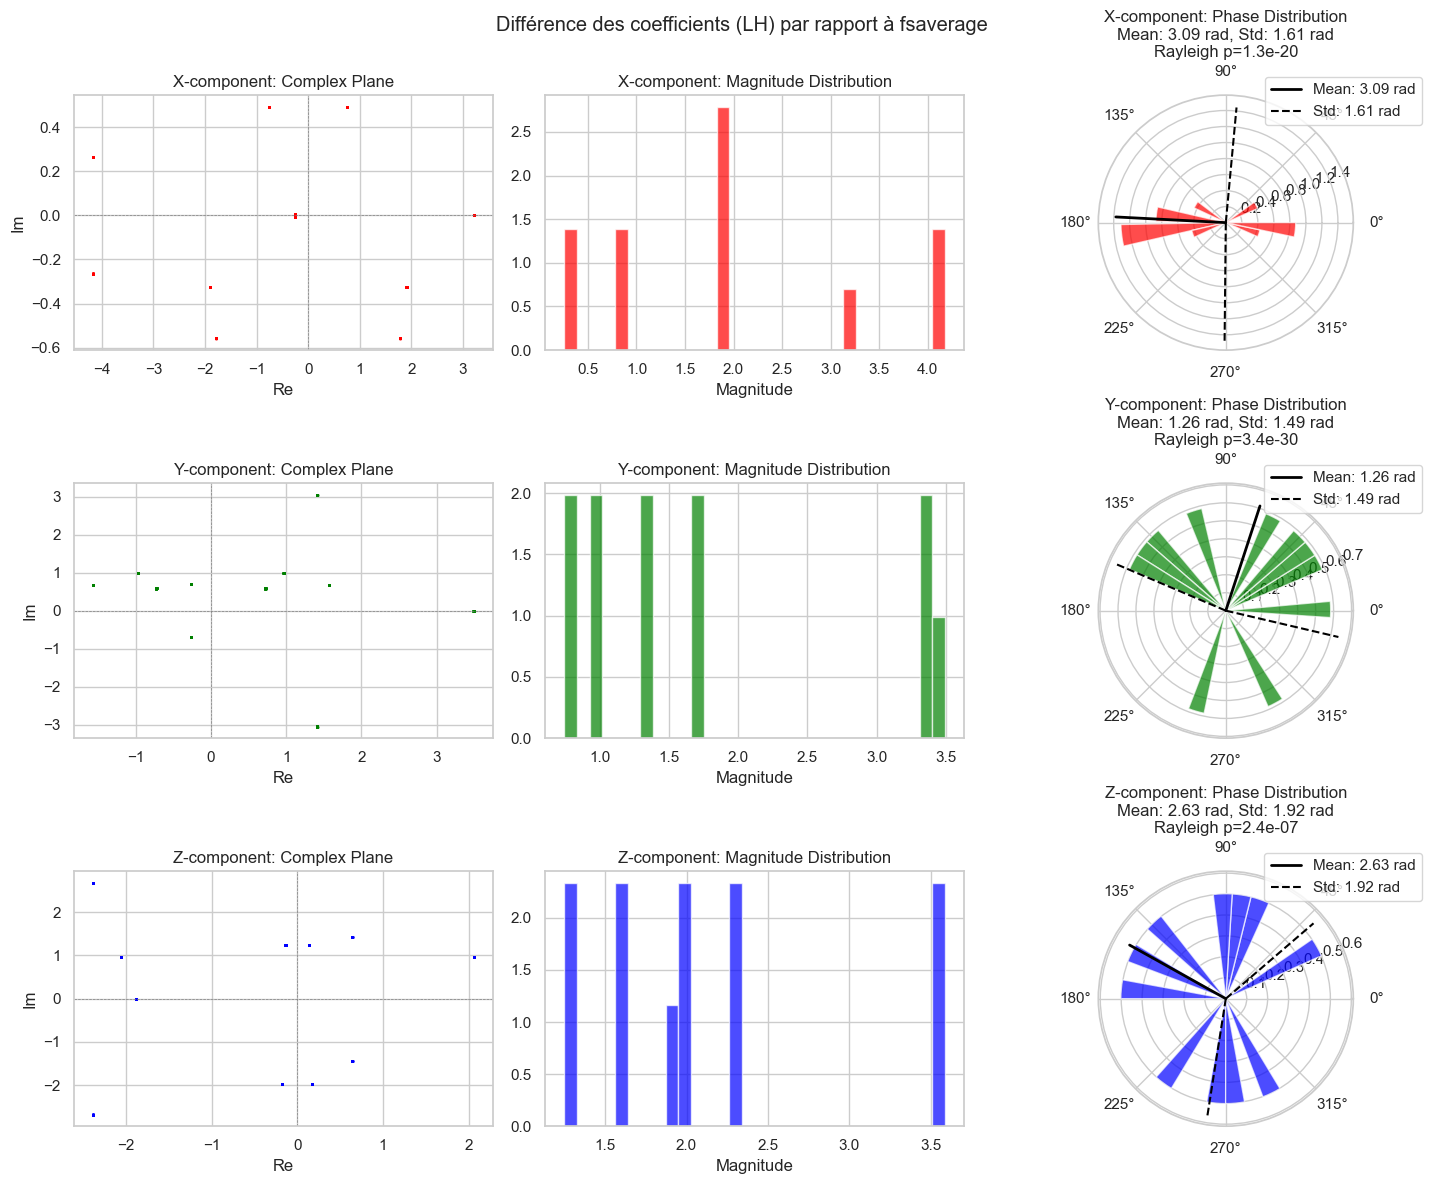

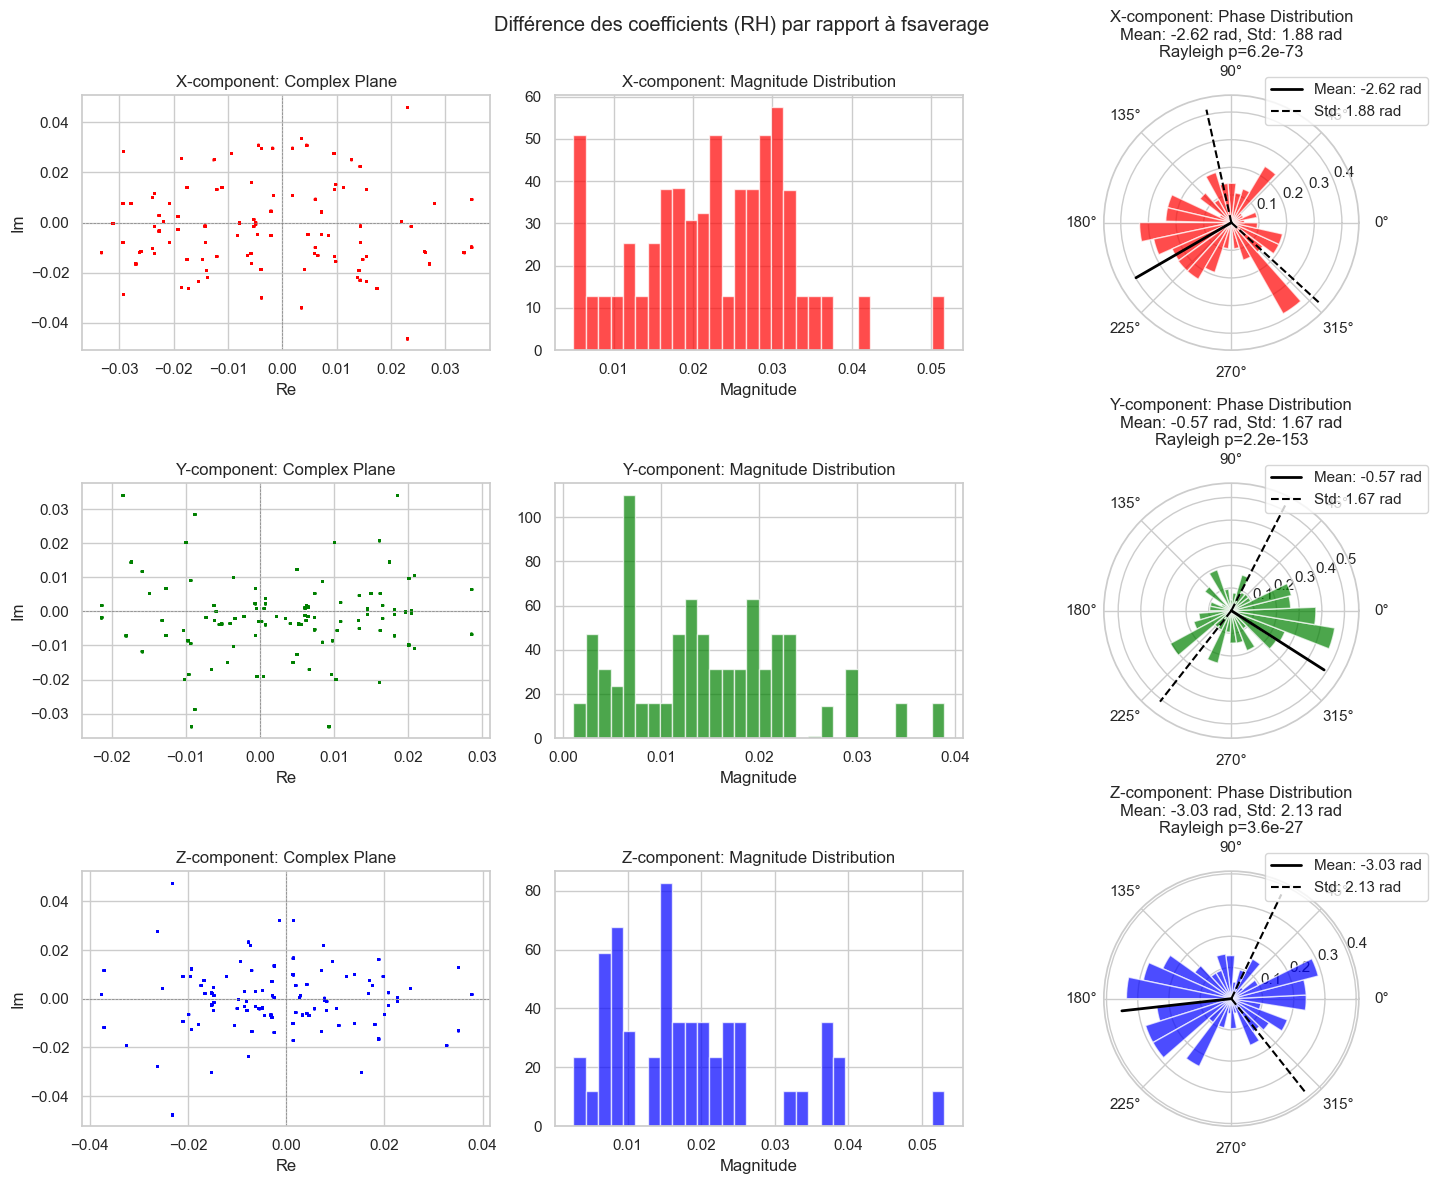

In [15]:
# Pour l'hémisphère gauche
fig_diff_lh, results_diff_lh = analyze_complex_coeffs(coeffs_diff_lh, l_value=5)
plt.suptitle("Différence des coefficients (LH) par rapport à fsaverage")

# Pour l'hémisphère droit
fig_diff_rh, results_diff_rh = analyze_complex_coeffs(coeffs_diff_rh, l_value=50)
plt.suptitle("Différence des coefficients (RH) par rapport à fsaverage")

# Afficher les résultats statistiques
print("Résultats pour l'hémisphère gauche (différences) :")
for result in results_diff_lh:
    print(f"Composante {result['component']}:")
    print(f"  Statistique de Rayleigh: {result['rayleigh_stat']:.4f}")
    print(f"  P-value: {result['p_value']:.4e}")
    print(f"  Moyenne de phase: {result['mean_phase']:.4f}")
    print(f"  Écart-type de phase: {result['std_phase']:.4f}")
    print()

print("\nRésultats pour l'hémisphère droit (différences) :")
for result in results_diff_rh:
    print(f"Composante {result['component']}:")
    print(f"  Statistique de Rayleigh: {result['rayleigh_stat']:.4f}")
    print(f"  P-value: {result['p_value']:.4e}")
    print(f"  Moyenne de phase: {result['mean_phase']:.4f}")
    print(f"  Écart-type de phase: {result['std_phase']:.4f}")
    print()

In [ ]:
def complex_normalized_stats(coeffs_diff_lh, coeffs_diff_rh, l_value):
    stats = {'LH': {'X': [], 'Y': [], 'Z': []},
             'RH': {'X': [], 'Y': [], 'Z': []}}
    
    # Collecte des valeurs
    for hemi, coeffs in [('LH', coeffs_diff_lh), ('RH', coeffs_diff_rh)]:
        for subject in coeffs:
            for m in range(-l_value, l_value + 1):
                for i, comp in enumerate(['X', 'Y', 'Z']):
                    val = coeffs[subject][l_value][m][i]
                    stats[hemi][comp].append(val)
    
    # Analyse séparée réel/imaginaire
    for hemi in ['LH', 'RH']:
        print(f"\nStatistiques pour {hemi}, l={l_value}:")
        for comp in ['X', 'Y', 'Z']:
            values = np.array(stats[hemi][comp])
            
            # Partie réelle
            cv_real = np.std(values.real) / np.mean(np.abs(values.real)) if np.mean(np.abs(values.real)) != 0 else 0
            print(f"\nComposante {comp} - Partie réelle:")
            print(f"  CV: {cv_real:.4f}")
            print(f"  Moyenne: {np.mean(values.real):.6f}")
            print(f"  Écart-type: {np.std(values.real):.6f}")
            
            # Partie imaginaire
            cv_imag = np.std(values.imag) / np.mean(np.abs(values.imag)) if np.mean(np.abs(values.imag)) != 0 else 0
            print(f"\nComposante {comp} - Partie imaginaire:")
            print(f"  CV: {cv_imag:.4f}")
            print(f"  Moyenne: {np.mean(values.imag):.6f}")
            print(f"  Écart-type: {np.std(values.imag):.6f}")

# Utilisation
complex_normalized_stats(coeffs_diff_lh, coeffs_diff_rh, l_value=60)

In [15]:
def visualize_perturbation(coeffs_fsav_lh, coeffs_fsav_rh, Y_lh, Y_rh,
                          tris_fsav_lh, tris_fsav_rh,
                          l, eps_real, eps_imag, lmax, sigma=1e-4):
    
    p = pv.Plotter(shape=(2,2))
    
    # Copier et slicer les coeffs de base jusqu'à lmax
    coeffs_lh_orig = {k: v.copy() for k,v in coeffs_fsav_lh.items() if k <= lmax}
    coeffs_rh_orig = {k: v.copy() for k,v in coeffs_fsav_rh.items() if k <= lmax}
    
    # Copier pour la version perturbée
    coeffs_lh = {k: v.copy() for k,v in coeffs_lh_orig.items()}
    coeffs_rh = {k: v.copy() for k,v in coeffs_rh_orig.items()}
    
    # Perturber l'ordre l avec partie réelle et imaginaire
    coeffs_lh[l] += (eps_real + 1j*eps_imag) * np.ones_like(coeffs_lh[l])
    coeffs_rh[l] += (eps_real + 1j*eps_imag) * np.ones_like(coeffs_rh[l])
    
    # Slicer Y_lh et Y_rh pour lmax
    Y_lh_sliced = Y_lh[:, :(lmax+1)**2]
    Y_rh_sliced = Y_rh[:, :(lmax+1)**2]
    
    # Générer toutes les surfaces
    surf_lh_orig = SH.generate_surface(Y_lh_sliced, lmax, sigma, coeffs_lh_orig)
    surf_lh_pert = SH.generate_surface(Y_lh_sliced, lmax, sigma, coeffs_lh)
    surf_rh_orig = SH.generate_surface(Y_rh_sliced, lmax, sigma, coeffs_rh_orig)
    surf_rh_pert = SH.generate_surface(Y_rh_sliced, lmax, sigma, coeffs_rh)

    # Left hemisphere original
    p.subplot(0,0)
    mesh_lh_orig = pv.PolyData(surf_lh_orig, convert_triangles_to_pyvista(tris_fsav_lh))
    p.add_mesh(mesh_lh_orig, color='lightblue', show_edges=True)
    
    # Left hemisphere perturbed
    p.subplot(0,1)
    mesh_lh_pert = pv.PolyData(surf_lh_pert, convert_triangles_to_pyvista(tris_fsav_lh))
    p.add_mesh(mesh_lh_pert, color='lightblue', show_edges=True)
    
    # Right hemisphere original
    p.subplot(1,0)
    mesh_rh_orig = pv.PolyData(surf_rh_orig, convert_triangles_to_pyvista(tris_fsav_rh))
    p.add_mesh(mesh_rh_orig, color='lightgreen', show_edges=True)
    
    # Right hemisphere perturbed
    p.subplot(1,1)
    mesh_rh_pert = pv.PolyData(surf_rh_pert, convert_triangles_to_pyvista(tris_fsav_rh))
    p.add_mesh(mesh_rh_pert, color='lightgreen', show_edges=True)
    
    p.link_views()
    p.show()

In [33]:
def compute_complex_kernel(X, Y=None, gamma=1.0):
    if Y is None:
        Y = X
    X_flat = X.reshape(X.shape[0], -1)
    Y_flat = Y.reshape(Y.shape[0], -1)
    
    # Traiter parties réelles et imaginaires séparément
    real_kernel = np.exp(-gamma * np.sum((X_flat.real[:, np.newaxis, :] - Y_flat.real[np.newaxis, :, :]) ** 2, axis=2))
    imag_kernel = np.exp(-gamma * np.sum((X_flat.imag[:, np.newaxis, :] - Y_flat.imag[np.newaxis, :, :]) ** 2, axis=2))
    
    return (real_kernel + imag_kernel) / 2

def matrix_svd_diff_harmonics(l, coeffs_diff):
    n_subjects = len(coeffs_diff)
    M_x = np.zeros((n_subjects, 2*l+1), dtype=complex)
    M_y = np.zeros((n_subjects, 2*l+1), dtype=complex)
    M_z = np.zeros((n_subjects, 2*l+1), dtype=complex)
    
    for i, subject in enumerate(coeffs_diff.keys()):
        for m in range(-l, l+1):
            m_idx = m + l
            M_x[i, m_idx] = coeffs_diff[subject][l][m][0]
            M_y[i, m_idx] = coeffs_diff[subject][l][m][1]
            M_z[i, m_idx] = coeffs_diff[subject][l][m][2]
            
    means_x = np.mean(M_x, axis=0)
    means_y = np.mean(M_y, axis=0)
    means_z = np.mean(M_z, axis=0)
    
    return M_x - means_x, M_y - means_y, M_z - means_z, means_x, means_y, means_z

def process_component_svd(M, diff, means, norm_orig=None):
    diff_centered = diff - means
    
    # Calcul du noyau
    gamma = 1.0 / M.shape[1]  # heuristique pour gamma
    K = compute_complex_kernel(M, gamma=gamma)
    
    # Centrage du noyau
    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    K_centered = K - K @ one_n - one_n @ K + one_n @ K @ one_n
    
    # Décomposition spectrale
    eigvals, eigvecs = np.linalg.eigh(K_centered)
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    
    # Projection
    K_test = compute_complex_kernel(diff_centered[np.newaxis, :], M, gamma=gamma)
    n_test = K_test.shape[0]
    K_test_centered = K_test - np.mean(K_test, axis=1)[:, np.newaxis]
    
    # Reconstruction
    n_components = min(n, int(0.9 * len(eigvals)))  # Garde 90% de la variance
    projection = K_test_centered @ eigvecs[:, :n_components]
    decoded = projection @ eigvecs[:, :n_components].T @ M
    decoded = decoded[0] + means
    
    if norm_orig is not None and np.linalg.norm(decoded) > 0:
        decoded *= norm_orig / np.linalg.norm(decoded)
        
    return decoded

def generate_surface_diff_SVD(Y, subject_id, coeffs_diff, fsav_coeffs, lmax, sigma=0, debug=False):
    xyz_total = SH.generate_surface(Y, lmax, sigma, fsav_coeffs).astype(np.complex128)
    
    total_components_original = 0  # Compte original
    total_components_pca = 0      # Compte après PCA
    
    if debug:
        debug_data = []
    
    for l in range(1, lmax + 1):
        # Compte original pour cet ordre l
        components_this_l = 3 * (2*l + 1)  # 3 composantes (x,y,z) * nombre de coefficients
        total_components_original += components_this_l
        
        M_x, M_y, M_z, means_x, means_y, means_z = matrix_svd_diff_harmonics(l, coeffs_diff)
        
        # Calcul du nombre de composantes retenues pour cet ordre l
        _, Sx, _ = np.linalg.svd(M_x, full_matrices=False)
        _, Sy, _ = np.linalg.svd(M_y, full_matrices=False)
        _, Sz, _ = np.linalg.svd(M_z, full_matrices=False)
        
        # On compte les valeurs singulières significatives (par exemple > 1e-10)
        n_components_x = np.sum(Sx > 1e-10)
        n_components_y = np.sum(Sy > 1e-10)
        n_components_z = np.sum(Sz > 1e-10)
        
        total_components_pca += (n_components_x + n_components_y + n_components_z)
        
        if debug:
            debug_data.append({
                'l': l,
                'orig_components': components_this_l,
                'pca_components': n_components_x + n_components_y + n_components_z
            })
        
        # Reste du code inchangé...
        diff_x = np.zeros(2*l+1, dtype=complex)
        diff_y = np.zeros(2*l+1, dtype=complex)
        diff_z = np.zeros(2*l+1, dtype=complex)
        
        for m in range(-l, l+1):
            m_idx = m + l
            diff = coeffs_diff[subject_id][l][m]
            diff_x[m_idx] = diff[0]
            diff_y[m_idx] = diff[1]
            diff_z[m_idx] = diff[2]
        
        norm_x = np.linalg.norm(diff_x)
        norm_y = np.linalg.norm(diff_y)
        norm_z = np.linalg.norm(diff_z)
        
        decoded_x = process_component_svd(M_x, diff_x, means_x, norm_x)
        decoded_y = process_component_svd(M_y, diff_y, means_y, norm_y)
        decoded_z = process_component_svd(M_z, diff_z, means_z, norm_z)
        
        idx_start = l * l
        idx_end = idx_start + 2*l + 1
        Y_block = Y[:, idx_start:idx_end]
        scale = np.exp(-l * (l + 1) * sigma)
        
        xyz_total[:, 0] += scale * (Y_block @ decoded_x)
        xyz_total[:, 1] += scale * (Y_block @ decoded_y)
        xyz_total[:, 2] += scale * (Y_block @ decoded_z)
    
    print(f"Nombre total de composantes original: {total_components_original}")
    print(f"Nombre total de composantes après PCA: {total_components_pca}")
    print(f"Réduction: {100 * (1 - total_components_pca/total_components_original):.2f}%")
    
    if debug:
        print("\nDétail par ordre harmonique l:")
        for d in debug_data:
            print(f"l={d['l']}: original={d['orig_components']}, PCA={d['pca_components']}, "
                  f"réduction={100 * (1 - d['pca_components']/d['orig_components']):.2f}%")
    
    xyz_real = np.real(xyz_total)
    xyz_real = xyz_real - np.mean(xyz_real, axis=0)
    
    if debug:
        return xyz_real, debug_data
    return xyz_real

# Surface reconstruite avec SVD
surface_lh_svd, debug_info = generate_surface_diff_SVD(
    Y=Y_lh_full,
    subject_id=subject,
    coeffs_diff=coeffs_diff_lh,
    fsav_coeffs=coeffs_fsav_lh,
    lmax=40,
    debug=True
)

# Surface originale reconstruite directement depuis les coefficients
surface_lh_orig = SH.generate_surface(Y_lh_full, lmax=40, sigma=0, orders=coeffs_all_lh[subject])

# Visualisation
p = pv.Plotter(shape=(1, 2))

# Surface originale
p.subplot(0, 0)
tris = convert_triangles_to_pyvista(template_projection_lh["sphere_tris"])
mesh_original = pv.PolyData(surface_lh_orig, tris)
p.add_mesh(mesh_original, show_edges=True)

# Surface reconstruite avec SVD
p.subplot(0, 1)
mesh_reconstructed = pv.PolyData(surface_lh_svd, tris)  # Maintenant surface_lh_svd est bien la surface
p.add_mesh(mesh_reconstructed, show_edges=True)

p.link_views()
p.show()

Nombre total de composantes original: 5040
Nombre total de composantes après PCA: 4494
Réduction: 10.83%

Détail par ordre harmonique l:
l=1: original=9, PCA=9, réduction=0.00%
l=2: original=15, PCA=15, réduction=0.00%
l=3: original=21, PCA=21, réduction=0.00%
l=4: original=27, PCA=27, réduction=0.00%
l=5: original=33, PCA=33, réduction=0.00%
l=6: original=39, PCA=39, réduction=0.00%
l=7: original=45, PCA=45, réduction=0.00%
l=8: original=51, PCA=51, réduction=0.00%
l=9: original=57, PCA=57, réduction=0.00%
l=10: original=63, PCA=63, réduction=0.00%
l=11: original=69, PCA=69, réduction=0.00%
l=12: original=75, PCA=75, réduction=0.00%
l=13: original=81, PCA=81, réduction=0.00%
l=14: original=87, PCA=87, réduction=0.00%
l=15: original=93, PCA=93, réduction=0.00%
l=16: original=99, PCA=99, réduction=0.00%
l=17: original=105, PCA=105, réduction=0.00%
l=18: original=111, PCA=111, réduction=0.00%
l=19: original=117, PCA=117, réduction=0.00%
l=20: original=123, PCA=123, réduction=0.00%
l=21: 

Widget(value='<iframe src="http://localhost:22301/index.html?ui=P_0x2a261e9f560_20&reconnect=auto" class="pyvi…

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class ComplexAutoencoder(nn.Module):
    def __init__(self, input_size, reduction_factor):
        super().__init__()
        self.input_size = input_size
        self.latent_dim = max(2, input_size // reduction_factor)
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size * 2, self.latent_dim),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, input_size * 2),
        )
        
    def forward(self, x):
        x_real = torch.real(x)
        x_imag = torch.imag(x)
        x_combined = torch.cat([x_real, x_imag], dim=-1)
        
        norm = torch.norm(x_combined, dim=-1, keepdim=True)
        x_normalized = x_combined / (norm + 1e-8)
        
        latent = self.encoder(x_normalized)
        output = self.decoder(latent)
        output = output * norm
        
        n = output.shape[-1] // 2
        return torch.complex(output[..., :n], output[..., n:])

def compute_vertex_normals(vertices, faces, vertex_to_faces, n_rings=2):
    vertex_conn, _ = build_sparse_connectivity(faces)
    face_normals = compute_face_normals(vertices, faces)
    vertex_normals = np.zeros_like(vertices)
    
    for vertex_idx in range(len(vertices)):
        local_faces = set(vertex_to_faces[vertex_idx])
        current_ring = set(vertex_to_faces[vertex_idx])
        for _ in range(n_rings - 1):
            next_ring = set()
            for face_idx in current_ring:
                neighbors = get_neighbor_faces(faces, face_idx, vertex_to_faces)
                next_ring.update(neighbors)
            local_faces.update(next_ring)
            current_ring = next_ring
        
        local_faces = list(local_faces)
        vertex_normals[vertex_idx] = np.sum(face_normals[local_faces], axis=0)
    
    norms = np.linalg.norm(vertex_normals, axis=1, keepdims=True)
    norms[norms == 0] = 1
    return vertex_normals / norms

def compute_face_normals(vertices, faces):
    v1 = vertices[faces[:,0]]
    v2 = vertices[faces[:,1]]
    v3 = vertices[faces[:,2]]
    return np.cross(v2 - v1, v3 - v1)

def get_neighbor_faces(faces, face_idx, vertex_to_faces):
    neighbor_faces = set()
    for vertex_idx in faces[face_idx]:
        neighbor_faces.update(vertex_to_faces[vertex_idx])
    return list(neighbor_faces)

def build_sparse_connectivity(faces):
    total_vertices = np.max(faces) + 1
    rows, cols = [], []
    for face in faces:
        v1, v2, v3 = face
        rows.extend([v1, v2, v3, v2, v3, v1])
        cols.extend([v2, v3, v1, v1, v2, v3])

    data = np.ones(len(rows), dtype=bool)
    vertex_conn = sparse.csr_matrix((data, (rows, cols)), 
                                  shape=(total_vertices, total_vertices))
    return vertex_conn, faces

def geometric_loss(output, target, vertices, faces, vertex_to_faces):
    # Point-to-point distance
    point_loss = F.mse_loss(torch.abs(output), torch.abs(target))
    
    # Normal computation
    output_vertices = torch.reshape(output, (-1, 3))
    target_vertices = torch.reshape(target, (-1, 3))
    
    output_normals = compute_vertex_normals(output_vertices.cpu().numpy(), 
                                          faces, 
                                          vertex_to_faces)
    target_normals = compute_vertex_normals(target_vertices.cpu().numpy(), 
                                          faces, 
                                          vertex_to_faces)
    
    output_normals = torch.tensor(output_normals, device=output.device)
    target_normals = torch.tensor(target_normals, device=target.device)
    
    # Normal angle difference
    normal_dots = torch.sum(output_normals * target_normals, dim=1)
    normal_dots = torch.clamp(normal_dots, -1.0, 1.0)
    normal_loss = torch.mean(torch.acos(normal_dots))

    return 0.6 * point_loss + 0.4 * normal_loss

def complex_loss(output, target, vertices, faces, vertex_to_faces):
    mag_loss = F.mse_loss(torch.abs(output), torch.abs(target))
    phase_loss = F.mse_loss(torch.angle(output), torch.angle(target))
    geom_loss = geometric_loss(output, target, vertices, faces, vertex_to_faces)
    return 0.4 * mag_loss + 0.3 * phase_loss + 0.3 * geom_loss

def train_autoencoder_for_order(l, coeffs_diff, vertices, faces, vertex_to_faces, 
                               device='cuda', reduction_factor=5):
    n_subjects = len(coeffs_diff)
    data_x = np.zeros((n_subjects, 2*l+1), dtype=complex)
    data_y = np.zeros((n_subjects, 2*l+1), dtype=complex)
    data_z = np.zeros((n_subjects, 2*l+1), dtype=complex)
    
    for i, subject in enumerate(coeffs_diff.keys()):
        for m in range(-l, l+1):
            m_idx = m + l
            data_x[i, m_idx] = coeffs_diff[subject][l][m][0]
            data_y[i, m_idx] = coeffs_diff[subject][l][m][1]
            data_z[i, m_idx] = coeffs_diff[subject][l][m][2]
    
    data_x = torch.tensor(data_x, dtype=torch.cfloat).to(device)
    data_y = torch.tensor(data_y, dtype=torch.cfloat).to(device)
    data_z = torch.tensor(data_z, dtype=torch.cfloat).to(device)
    
    input_size = 2*l+1
    ae_x = ComplexAutoencoder(input_size, reduction_factor).to(device)
    ae_y = ComplexAutoencoder(input_size, reduction_factor).to(device)
    ae_z = ComplexAutoencoder(input_size, reduction_factor).to(device)
    
    optimizers = [optim.Adam(ae.parameters(), lr=0.001) for ae in [ae_x, ae_y, ae_z]]
    
    vertices_tensor = torch.tensor(vertices, device=device)
    
    n_epochs = 2000
    batch_size = min(8, n_subjects)
    dataset = TensorDataset(data_x, data_y, data_z)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(n_epochs):
        total_loss = 0
        for batch_x, batch_y, batch_z in loader:
            for ae, data, opt in zip([ae_x, ae_y, ae_z], [batch_x, batch_y, batch_z], optimizers):
                opt.zero_grad()
                output = ae(data)
                loss = complex_loss(output, data, vertices_tensor, faces, vertex_to_faces)
                loss.backward()
                opt.step()
                total_loss += loss.item()
        
        if epoch % 500 == 0:
            print(f'l={l}, Epoch {epoch}, Loss: {total_loss/len(loader):.6f}')
    
    return ae_x, ae_y, ae_z

def generate_surface_diff_AE(Y, subject_id, coeffs_diff, fsav_coeffs, vertices, faces, vertex_to_faces, lmax, sigma=0):
    xyz_total = SH.generate_surface(Y, lmax, sigma, fsav_coeffs).astype(np.complex128)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    total_dim_original = 0
    total_dim_reduced = 0
    
    for l in range(1, lmax + 1):
        input_dim = 2*l + 1
        
        # No reduction for l ≤ 10
        if l <= 10:
            reduced_dim = input_dim
        else:
            reduction_factor = max(2, (l - 10) // 3 + 5)  
            reduced_dim = max(2, input_dim // reduction_factor)
        
        dim_original_this_l = 3 * input_dim
        dim_reduced_this_l = 3 * reduced_dim
        
        total_dim_original += dim_original_this_l
        total_dim_reduced += dim_reduced_this_l
        
        print(f"\nOrder l={l}:")
        print(f"Original dim: {dim_original_this_l}")
        print(f"Reduced dim: {dim_reduced_this_l}")
        print(f"Reduction: {100 * (1 - dim_reduced_this_l/dim_original_this_l):.2f}%")
        
        # Skip autoencoder for l ≤ 10
        if l <= 10:
            for comp in ['x', 'y', 'z']:
                idx = {'x': 0, 'y': 1, 'z': 2}[comp]
                Y_block = Y[:, l*l:l*l + 2*l+1]
                scale = np.exp(-l * (l + 1) * sigma)
                
                coeffs = np.array([coeffs_diff[subject_id][l][m][idx] for m in range(-l, l+1)])
                xyz_total[:, idx] += scale * (Y_block @ coeffs)
            continue
            
        # Use autoencoder with progressive reduction for l > 10
        ae_x, ae_y, ae_z = train_autoencoder_for_order(l, coeffs_diff, vertices, faces, vertex_to_faces,
                                                      device, reduction_factor=(l - 10) // 3 + 5)
        
        means = {comp: np.zeros(2*l+1, dtype=complex) for comp in ['x', 'y', 'z']}
        diffs = {comp: np.zeros(2*l+1, dtype=complex) for comp in ['x', 'y', 'z']}
        
        for m in range(-l, l+1):
            m_idx = m + l
            for i, comp in enumerate(['x', 'y', 'z']):
                means[comp][m_idx] = np.mean([coeffs_diff[s][l][m][i] for s in coeffs_diff.keys()])
                diffs[comp][m_idx] = coeffs_diff[subject_id][l][m][i]
        
        for comp, ae in zip(['x', 'y', 'z'], [ae_x, ae_y, ae_z]):
            diff = diffs[comp]
            mean = means[comp]
            norm = np.linalg.norm(diff)
            
            with torch.no_grad():
                diff_tensor = torch.tensor(diff - mean, dtype=torch.cfloat).to(device)
                decoded = ae(diff_tensor).cpu().numpy() + mean
                
                if norm > 0:
                    decoded *= norm / np.linalg.norm(decoded)
            
            idx = {'x': 0, 'y': 1, 'z': 2}[comp]
            Y_block = Y[:, l*l:l*l + 2*l+1]
            scale = np.exp(-l * (l + 1) * sigma)
            xyz_total[:, idx] += scale * (Y_block @ decoded)
    
    print(f"\nTotal dimensions:")
    print(f"Original: {total_dim_original}")
    print(f"Reduced: {total_dim_reduced}")
    print(f"Overall reduction: {100 * (1 - total_dim_reduced/total_dim_original):.2f}%")
    
    xyz_real = np.real(xyz_total)
    return xyz_real - np.mean(xyz_real, axis=0)

def visualize_results(surface_lh_orig, surface_lh_ae, template_projection_lh):
    p = pv.Plotter(shape=(1, 2))
    tris = convert_triangles_to_pyvista(template_projection_lh["sphere_tris"])
    
    # Original surface
    p.subplot(0, 0)
    mesh_original = pv.PolyData(surface_lh_orig, tris)
    p.add_mesh(mesh_original, show_edges=True)
    
    # Reconstructed surface
    p.subplot(0, 1)
    mesh_reconstructed = pv.PolyData(surface_lh_ae, tris)
    p.add_mesh(mesh_reconstructed, show_edges=True)
    
    p.link_views()
    p.show()

NameError: name '_C' is not defined

In [ ]:
# def find_matching_l(target_dims):
#     l = 0
#     while 3*(l+1)**2 <= target_dims:
#         l += 1
#     return l
# lmin1= -1
# lmax1=30
# coords_pca, dims_intact, dims_pca = generate_surface_SVD(Y, subject_coeffs, lmin1, lmax1, coeffs_all_lh)
# total_dims = dims_intact + dims_pca

# l_equiv = find_matching_l(total_dims)
# coords_direct = SH.generate_surface(Y, l_equiv, 0, subject_coeffs)

# print(f"Original dimensions: {3*(lmax1+1)**2}")
# print(f"Our method: {dims_intact} (intact) + {dims_pca} (PCA) = {total_dims}")
# print(f"Equivalent l={l_equiv} giving {3*(l_equiv+1)**2} dimensions")



# # Original surface
# coords_original = np.load(os.path.join(sub_file, "lh_resampled.npz"))["coords"]

# # Errors
# error_pca = hausdorff_distance(coords_original, coords_pca) / np.max(np.ptp(coords_original, axis=0))
# error_direct = hausdorff_distance(coords_original, coords_direct) / np.max(np.ptp(coords_original, axis=0))

# print(f"PCA error: {error_pca}")
# print(f"Direct error (l={l_equiv}): {error_direct}")
# # Visualization
# p = pv.Plotter(shape=(1, 3))
# tris = convert_triangles_to_pyvista(template_projection["sphere_tris"])

# p.subplot(0, 0)
# p.add_mesh(pv.PolyData(coords_pca, tris), show_edges=True)
# p.add_text("PCA", position='upper_edge')

# p.subplot(0, 1)
# p.add_mesh(pv.PolyData(coords_direct, tris), show_edges=True)
# p.add_text("Direct", position='upper_edge')

# p.subplot(0, 2)
# p.add_mesh(pv.PolyData(coords_original, tris), show_edges=True)
# p.add_text("Original", position='upper_edge')

# p.link_views()
# p.show()

Study of the geometrical deformation after a little change of the coefficients given a order

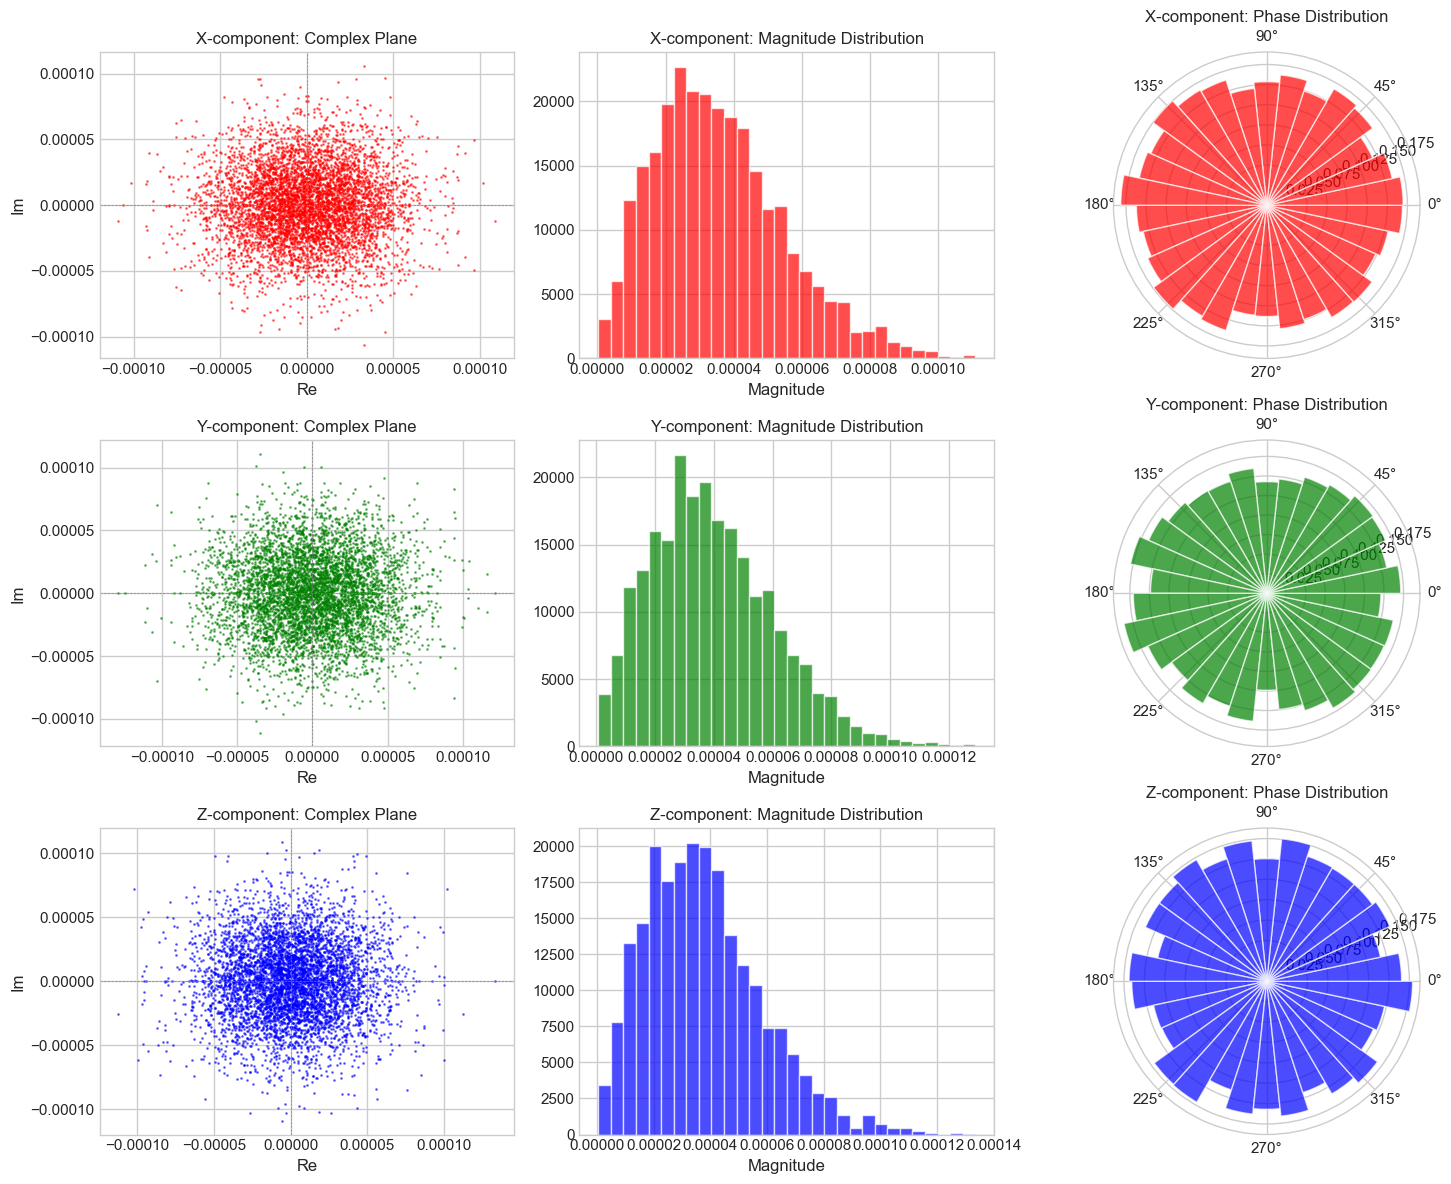

In [96]:
fig, results = analyze_complex_coeffs(coeffs_all_lh, 50)

# Affichage des résultats du test de Rayleigh pour chaque composante

# Affichage des graphiques
plt.show()

In [15]:
def plot_coeffs_distribution_lm(coeffs_all, l_value, m_value):
    # Extract coefficients
    coeffs_x = []
    coeffs_y = []
    coeffs_z = []
    
    for subject in coeffs_all:
        vector = coeffs_all[subject][l_value][m_value]
        coeffs_x.append(vector[0])
        coeffs_y.append(vector[1])
        coeffs_z.append(vector[2])
    
    coeffs_x = np.array(coeffs_x)
    coeffs_y = np.array(coeffs_y)
    coeffs_z = np.array(coeffs_z)
    
    # Create figure with 3 rows and 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    colors = ['red', 'green', 'blue']
    cmaps = ['Reds', 'Greens', 'Blues']
    components = [(coeffs_x, 'X'), (coeffs_y, 'Y'), (coeffs_z, 'Z')]
    
    for i, (coeffs, comp_name) in enumerate(components):
        ax1, ax2, ax3 = axes[i]
        
        # Distribution dans le plan complexe
        sns.kdeplot(x=coeffs.real, y=coeffs.imag, ax=ax1, cmap=cmaps[i], fill=True)
        ax1.scatter(coeffs.real, coeffs.imag, alpha=0.2, color=colors[i], label=f'{comp_name}-component')
        ax1.set_title(f'{comp_name}-component: Complex plane (l={l_value}, m={m_value})')
        ax1.set_xlabel('Real part')
        ax1.set_ylabel('Imaginary part')
        ax1.grid(True)
        ax1.legend()
        
        # Magnitude
        sns.histplot(data=np.abs(coeffs), ax=ax2, kde=True, color=colors[i])
        ax2.set_title(f'{comp_name}-component: Magnitude')
        ax2.set_xlabel('|coefficient|')
        
        # Phase
        phases = np.angle(coeffs, deg=True)  # Convert to degrees
        sns.histplot(data=phases, ax=ax3, kde=True, color=colors[i])
        ax3.set_title(f'{comp_name}-component: Phase')
        ax3.set_xlabel('Phase (degrees)')
        
    plt.tight_layout()
    return fig

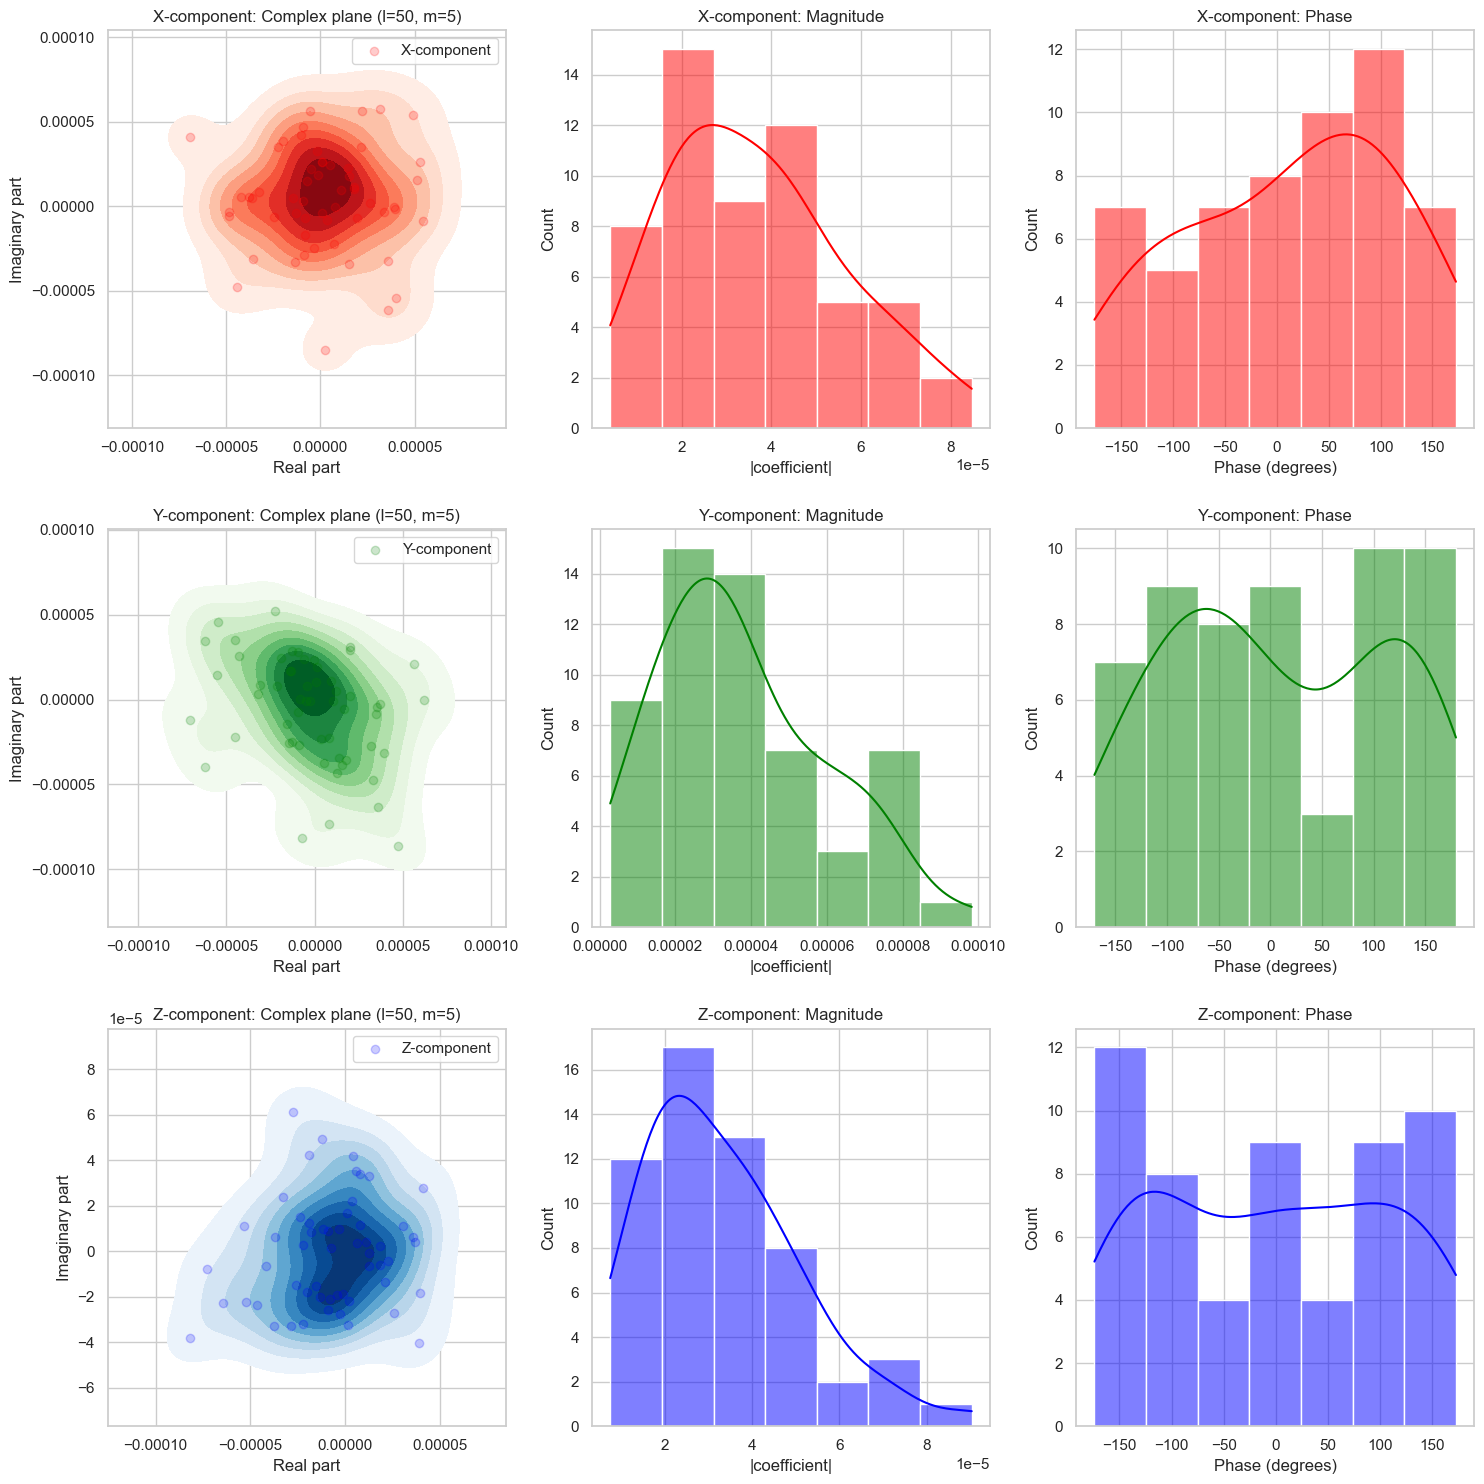

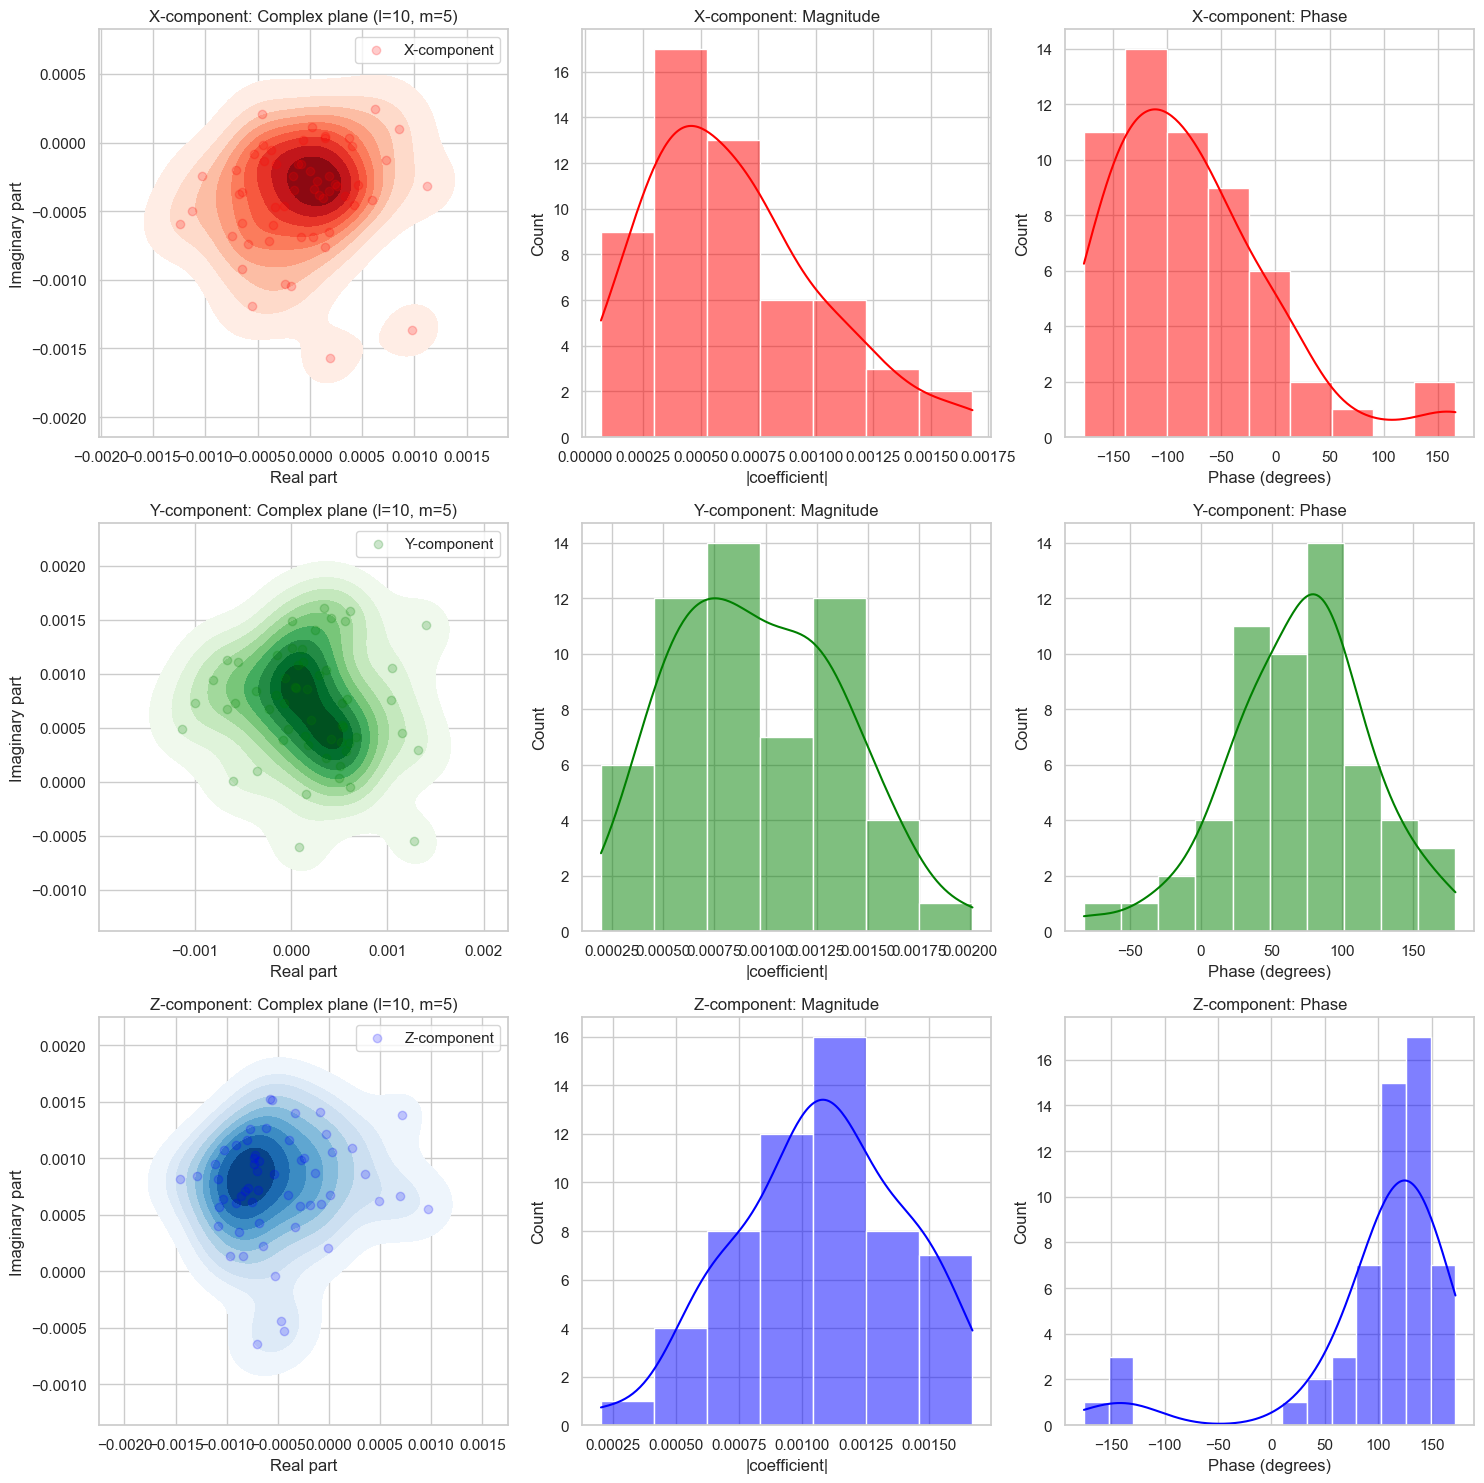

In [17]:
fig = plot_coeffs_distribution_lm(coeffs_all_lh,50,5)
fig = plot_coeffs_distribution_lm(coeffs_all_lh,10,5)
# fig = plot_coeffs_distribution_lm(coeffs_all_lh,10,-2)

In [15]:

def change_representations(coeffs_dic):
    lmax=coeffs_dic["lmax"]
    coeffs=coeffs_dic["organized_coeffs"]
    a = {l: [] for l in range(lmax+1)}
    b = {l: [] for l in range(lmax+1)}
    for l in range(lmax+1):
        a[l].append(coeffs[l][l].real)  
        b[l].append(np.array([0.,0.,0.]))  
        for m in range(1, l+1):
            # For C_lm : index l+m
            # For C_l(-m) : index l-m
            a[l].append(coeffs[l][l+m].real + ((-1)**m)*coeffs[l][l-m].real)
            b[l].append(((-1)**m)*coeffs[l][l-m].imag - coeffs[l][l+m].imag)
    return a, b

def spectral_power_order(a, b, l):
    return np.sum(np.array(a[l])**2 + np.array(b[l])**2, axis=0)

def spectral_power_coords(a,b,lmax):
    s_p=np.sum(np.array([spectral_power_order(a,b,l) for l in range(lmax+1)]), axis=0)
    return s_p

def spectral_power_dims_order(a, b, l):
    power = np.zeros(3)
    for i in range(3):
        power[i] = np.sum(np.array(a[l])[:,i]**2 + np.array(b[l])[:,i]**2)
    return power

def spectral_power_total(a,b,lmax):
    s_p=spectral_power_coords(a,b,lmax)
    return np.sum(s_p)

def correlation_order(u,v,l):
    a_u,b_u = u
    a_v,b_v = v
    return np.sum(np.array(a_u[l])*np.array(a_v[l])+(np.array(b_u[l])*np.array(b_v[l])),axis=0)

def correlation_coords(u,v,lmax):
     c_c=np.sum(np.array([correlation_order(u,v,l) for l in range(lmax+1)]), axis=0)
     return c_c

def correlation_dims_order(u,v,l):
   a_u,b_u = u
   a_v,b_v = v
   corr = np.zeros((3,3))
   for i in range(3):
       for j in range(3):
           corr[i,j] = np.sum(np.array(a_u[l])[:,i]*np.array(a_v[l])[:,j] + np.array(b_u[l])[:,i]*np.array(b_v[l])[:,j])
   return corr

def correlation_total(u,v,lmax):  
    return np.sum(correlation_coords(u,v,lmax))

In [42]:
def coherence_order(u, v, l):
    a_u, b_u = u
    a_v, b_v = v
    
    # Pour chaque composante, on calcule la cohérence entre les mêmes dimensions
    coherence = np.zeros(3)
    for i in range(3):  # i est la composante (x,y,z)
        u_complex = np.array(a_u[l])[:,i] + 1j * np.array(b_u[l])[:,i]
        v_complex = np.array(a_v[l])[:,i] + 1j * np.array(b_v[l])[:,i]
        
        # Spectre croisé pour une seule composante
        cross_spectrum = np.sum(u_complex * np.conjugate(v_complex))
        
        # Auto-spectres pour la même composante
        power_u = np.sum(np.abs(u_complex)**2)
        power_v = np.sum(np.abs(v_complex)**2)
        
        coherence[i] = np.abs(cross_spectrum)**2 / (power_u * power_v)
            
    return coherence


def compute_mean_coherence(coeffs_ab, lmax):
   coherences = {l: [] for l in range(lmax+1)}
   
   for i, participant1 in enumerate(coeffs_ab):
       for j, participant2 in enumerate(coeffs_ab):
           if i < j:
               for l in range(lmax+1):
                   coh = coherence_order(
                       (coeffs_ab[participant1]['lh'][0], coeffs_ab[participant1]['lh'][1]),
                       (coeffs_ab[participant2]['lh'][0], coeffs_ab[participant2]['lh'][1]),
                       l
                   )
                   coherences[l].append(coh)
   
   mean_coherences = [np.mean(coherences[l], axis=0) for l in range(1, lmax+1)]
   return np.array(mean_coherences)

In [86]:

subj_coeffs = r'C:\Users\wbou2\Desktop\meg_to_surface_ml\data\Anatomy_data_CAM_CAN\sub-CC110033\coeffs_lh.pkl'
with open(subj_coeffs, 'rb') as f:
    coeffs_lh = pickle.load(f)

a,b=change_representations(coeffs_lh)

from scipy.special import sph_harm

def reconstruct_surface(a, b, theta, phi, lmax):
   surface = np.zeros((len(theta), 3), dtype=float)
   
   for l in range(lmax+1):
       P_l0 = sph_harm(0, l, theta, phi)
       surface += np.outer(P_l0.real, a[l][0])  
       for m in range(1, l+1):
           P_lm = sph_harm(m, l, theta, phi)
           surface +=  np.outer(P_lm.real, a[l][m]) + np.outer(P_lm.imag, b[l][m]) 
   
   return surface

theta=template_projection['theta']
phi=template_projection['phi']

coords=reconstruct_surface(a,b,theta,phi,lmax)

tris=convert_triangles_to_pyvista(template_projection["sphere_tris"])
p=pv.Plotter()
mesh=pv.PolyData(coords,tris)
p.add_mesh(mesh)
p.show()

Widget(value='<iframe src="http://localhost:3219/index.html?ui=P_0x12e2578b170_1&reconnect=auto" class="pyvist…

In [18]:
coeffs_ab = {}

for folder in os.listdir(main_folder):
   folder_path = os.path.join(main_folder, folder)
   if os.path.isdir(folder_path):
       with open(os.path.join(folder_path, "coeffs_lh.pkl"), 'rb') as f:
           coeffs_lh = pickle.load(f)
       with open(os.path.join(folder_path, "coeffs_rh.pkl"), 'rb') as f:
           coeffs_rh = pickle.load(f)
       coeffs_ab[folder] = {
           'lh': change_representations(coeffs_lh),
           'rh': change_representations(coeffs_rh)
       }

In [ ]:
lmin=15

for l in range(lmin, 71, 5):
   alh = [np.array(coeffs_ab[x]['lh'][0][l][m]).T[0] for x in coeffs_ab.keys() for m in range(l+1)]
   blh = [np.array(coeffs_ab[x]['lh'][1][l][m]).T[0] for x in coeffs_ab.keys() for m in range(l+1)]
   arh = [np.array(coeffs_ab[x]['rh'][0][l][m]).T[0] for x in coeffs_ab.keys() for m in range(l+1)]
   brh = [np.array(coeffs_ab[x]['rh'][1][l][m]).T[0] for x in coeffs_ab.keys() for m in range(l+1)]

   max_val = max([max(abs(np.array(alh))), max(abs(np.array(blh))), 
                 max(abs(np.array(arh))), max(abs(np.array(brh)))])
   limit = max_val * 1.2

   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
   fig.suptitle(f'Distribution des coefficients pour l={l}')

   sns.histplot(data=alh, ax=ax1, color='blue', alpha=0.5, label='a', kde=True)
   sns.histplot(data=blh, ax=ax1, color='red', alpha=0.5, label='b', kde=True)
   ax1.set_title('LH - coefficients')
   ax1.set_xlim(-limit, limit)
   ax1.legend()

   sns.histplot(data=arh, ax=ax2, color='blue', alpha=0.5, label='a', kde=True)
   sns.histplot(data=brh, ax=ax2, color='red', alpha=0.5, label='b', kde=True)
   ax2.set_title('RH - coefficients')
   ax2.set_xlim(-limit, limit)
   ax2.legend()

   plt.tight_layout()
   plt.show()

Analysis from a spectrum point of view 

In [19]:
powers_lh = {l: [] for l in range(lmax+1)}
powers_rh = {l: [] for l in range(lmax+1)}

for participant in coeffs_ab:
    for l in range(lmax+1):
        powers_lh[l].append(spectral_power_order(coeffs_ab[participant]['lh'][0], coeffs_ab[participant]['lh'][1], l))
        powers_rh[l].append(spectral_power_order(coeffs_ab[participant]['rh'][0], coeffs_ab[participant]['rh'][1], l))

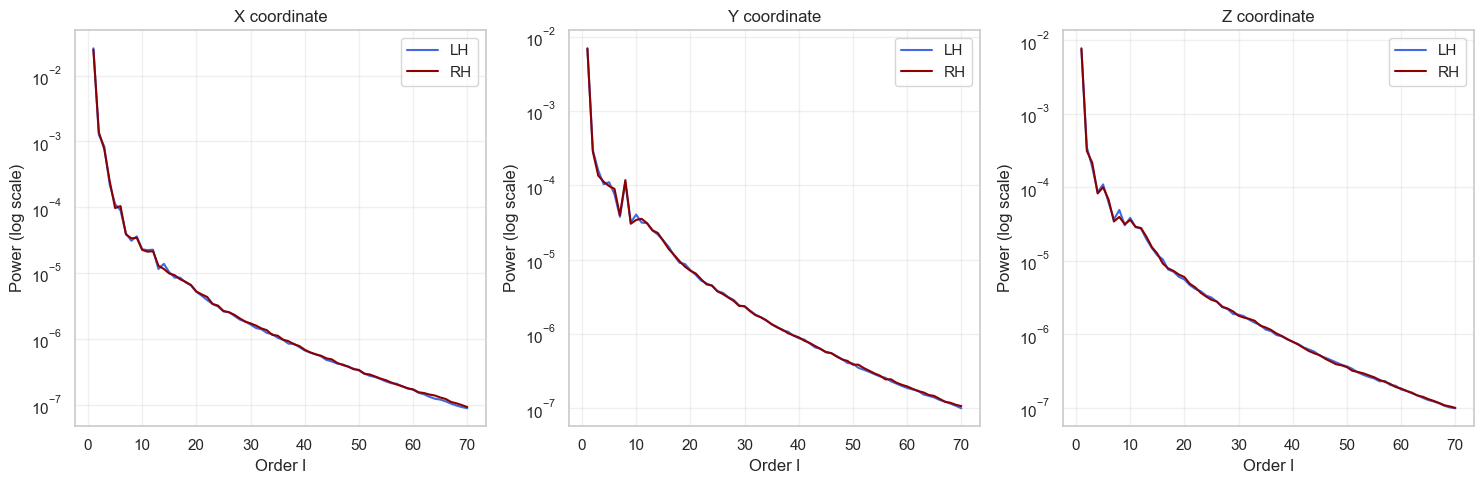

In [32]:
lmin = 1
mean_power_lh = []
mean_power_rh = []

for l in range(lmin, lmax+1):
    mean_power_lh.append(np.mean(np.array(powers_lh[l]), axis=0))
    mean_power_rh.append(np.mean(np.array(powers_rh[l]), axis=0))

mean_power_lh = np.array(mean_power_lh)
mean_power_rh = np.array(mean_power_rh)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# X coordinate
ax1.semilogy(range(lmin,lmax+1), mean_power_lh.T[0], 'royalblue', label="LH")
ax1.semilogy(range(lmin,lmax+1), mean_power_rh.T[0], 'darkred', label="RH")
ax1.set_title('X coordinate')
ax1.set_xlabel('Order l')
ax1.set_ylabel('Power (log scale)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Y coordinate
ax2.semilogy(range(lmin,lmax+1), mean_power_lh.T[1], 'royalblue', label="LH")
ax2.semilogy(range(lmin,lmax+1), mean_power_rh.T[1], 'darkred', label="RH")
ax2.set_title('Y coordinate')
ax2.set_xlabel('Order l')
ax2.set_ylabel('Power (log scale)')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Z coordinate
ax3.semilogy(range(lmin,lmax+1), mean_power_lh.T[2], 'royalblue', label="LH")
ax3.semilogy(range(lmin,lmax+1), mean_power_rh.T[2], 'darkred', label="RH")
ax3.set_title('Z coordinate')
ax3.set_xlabel('Order l')
ax3.set_ylabel('Power (log scale)')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()
plt.show()

In [43]:
coherences = {l: [] for l in range(lmax+1)}

# Pour chaque paire de participants
for i, participant1 in enumerate(coeffs_ab):
    for j, participant2 in enumerate(coeffs_ab):
        if i < j:
            for l in range(lmax+1):
                coh = coherence_order(
                    (coeffs_ab[participant1]['lh'][0], coeffs_ab[participant1]['lh'][1]),
                    (coeffs_ab[participant2]['lh'][0], coeffs_ab[participant2]['lh'][1]),
                    l
                )
                coherences[l].append(coh)  # coh contient [cohX, cohY, cohZ]

mean_coherences = [np.mean(coherences[l], axis=0) for l in range(1, lmax+1)]
mean_coherences = np.array(mean_coherences)  # shape: (lmax, 3)


Study of the correlation

In [44]:
# Pour chaque composante (x,y,z)
for i in range(3):
   comp_coh = mean_coherences[:,i]  # Prend toutes les valeurs l pour une composante
   try:
       l_threshold = [l+1 for l,c in enumerate(comp_coh) if c < 0.7][0]
       # Vérifie que les prochaines valeurs restent sous le seuil
       next_values = comp_coh[l_threshold-1:l_threshold+2]
       if all(v < 0.7 for v in next_values):
           print(f"Composante {i}: l={l_threshold}")
       else:
           # Continue à chercher si c'était une fluctuation temporaire
           l_threshold = [l+1 for l,c in enumerate(comp_coh[l_threshold:]) if c < 0.7 and 
                        all(v < 0.7 for v in comp_coh[l:l+3])][0] + l_threshold
           print(f"Composante {i}: l={l_threshold}")
   except IndexError:
       print(f"Composante {i}: jamais < 0.7")

Composante 0: l=7
Composante 1: l=6
Composante 2: l=10


In [34]:
correlations = {l: [] for l in range(lmax+1)}

# For each pair of participants
for i, participant1 in enumerate(coeffs_ab):
   for j, participant2 in enumerate(coeffs_ab):
       if i < j:
           for l in range(lmax+1):
               corr_lh = correlation_order(
                   (coeffs_ab[participant1]['lh'][0], coeffs_ab[participant1]['lh'][1]),
                   (coeffs_ab[participant2]['lh'][0], coeffs_ab[participant2]['lh'][1]),
                   l
               )

               norm = np.sqrt(powers_lh[l][i] * powers_lh[l][j])
               correlations[l].append(corr_lh/norm)

In [35]:
mean_correlations=[np.mean(correlations[l],axis=0) for l in range(1,lmax+1)]
mean_correlations = np.array(mean_correlations)


for i in range(mean_correlations[0].shape[0]):
    comp_corr = mean_correlations.T[i]
    l_threshold = [l+1 for l,c in enumerate(comp_corr) if c <0.05][0]
    print(f"Composante {i}: l={l_threshold}")

Composante 0: l=28
Composante 1: l=30
Composante 2: l=27


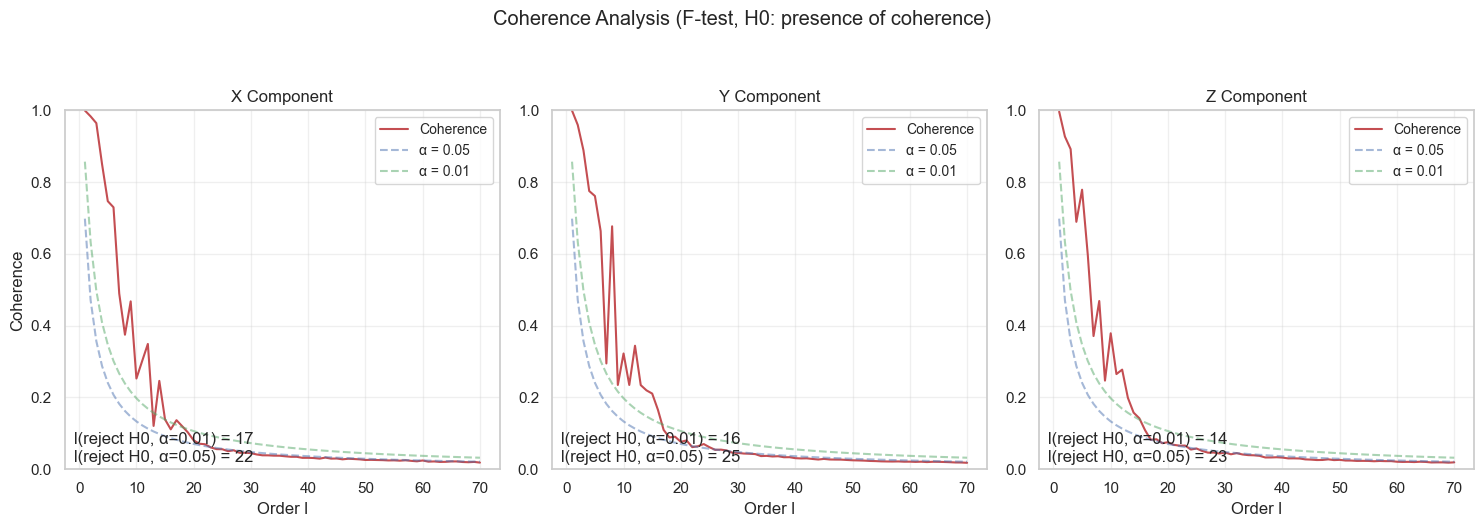

<Figure size 640x480 with 0 Axes>

In [51]:
# Calculate number of pairs
n_subjects = 56
n_pairs = (n_subjects * (n_subjects - 1)) // 2

def get_coherence_threshold(alpha, n_independent):
    """
    Test H0: présence de cohérence vs H1: absence de cohérence
    Utilise la distribution F (rapport de variances) pour tester la présence de cohérence
    """
    from scipy.stats import f
    # Les degrés de liberté sont liés à la dimension des harmoniques sphériques
    critical_value = f.ppf(1-alpha, dfn=2, dfd=2*(n_independent-1))
    # Conversion en seuil de cohérence
    threshold = critical_value / (critical_value + n_independent)
    return threshold

def get_ndof(l):
    # Degrés de liberté pour les harmoniques sphériques
    return 2*l + 1

def find_first_no_coherence(data, alpha=0.05):
    """
    Trouve le premier l où on peut rejeter H0 (présence de cohérence)
    """
    for l, value in enumerate(data[1:], start=1):
        ndof = get_ndof(l)
        threshold = get_coherence_threshold(alpha, ndof)
        if value < threshold:  # On rejette H0 si la cohérence est sous le seuil
            # Vérifie les ordres suivants pour éviter les faux positifs
            next_values = data[l:l+3]
            next_thresholds = [get_coherence_threshold(alpha, get_ndof(l+i)) for i in range(3)]
            if all(v < t for v,t in zip(next_values, next_thresholds)):
                return l
    return None

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

def setup_coherence_plot(ax, data, title):
    ax.plot(range(1,lmax+1), data, '-r', label='Coherence')
    
    # Significance levels
    l_range = range(1,lmax+1)
    thresholds_05 = [get_coherence_threshold(0.05, get_ndof(l)) for l in l_range]
    thresholds_01 = [get_coherence_threshold(0.01, get_ndof(l)) for l in l_range]
    
    ax.plot(l_range, thresholds_05, '--b', alpha=0.5, label='α = 0.05')
    ax.plot(l_range, thresholds_01, '--g', alpha=0.5, label='α = 0.01')
    
    # First l where H0 is rejected
    l_05 = find_first_no_coherence(data, 0.05)
    l_01 = find_first_no_coherence(data, 0.01)
    
    if l_05:
        ax.text(0.02, 0.02, f'l(reject H0, α=0.05) = {l_05}', transform=ax.transAxes)
    if l_01:
        ax.text(0.02, 0.07, f'l(reject H0, α=0.01) = {l_01}', transform=ax.transAxes)
    
    ax.set_xlabel('Order l')
    ax.set_ylabel("Coherence" if title == "X Component" else "")
    ax.set_title(title)
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize='small')

# Setup each subplot
setup_coherence_plot(ax1, np.array(mean_coherences).T[0], "X Component")
setup_coherence_plot(ax2, np.array(mean_coherences).T[1], "Y Component")
setup_coherence_plot(ax3, np.array(mean_coherences).T[2], "Z Component")

plt.suptitle("Coherence Analysis (F-test, H0: presence of coherence)", y=1.05)
plt.tight_layout()
plt.show()

# Setup each subplot
setup_coherence_plot(ax1, np.array(mean_coherences).T[0], "X Component")
setup_coherence_plot(ax2, np.array(mean_coherences).T[1], "Y Component")
setup_coherence_plot(ax3, np.array(mean_coherences).T[2], "Z Component")

plt.suptitle("Coherence Analysis (F-test, H0: presence of coherence)", y=1.05)
plt.tight_layout()
plt.show()

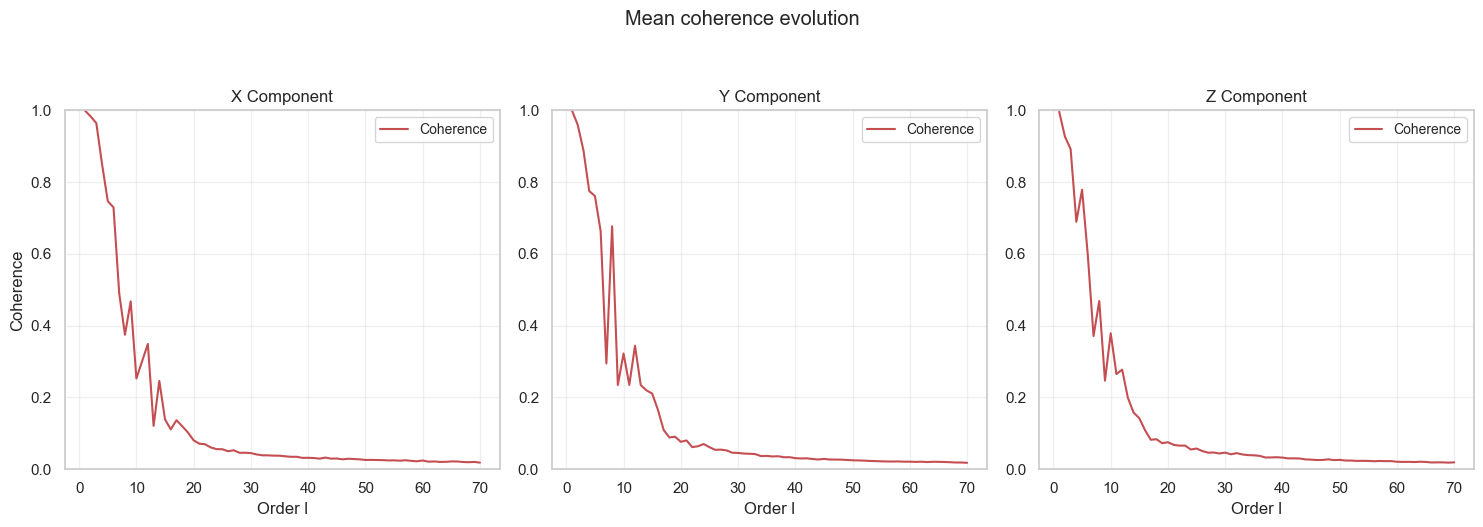

In [55]:
# Calculate number of pairs
n_subjects = 56
n_pairs = (n_subjects * (n_subjects - 1)) // 2  


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

def setup_coherence_plot(ax, data, title):
   ax.plot(range(1,lmax+1), data, '-r', label='Coherence')
   
   ax.set_xlabel('Order l')
   ax.set_ylabel("Coherence" if title == "X Component" else "")
   ax.set_title(title)
   ax.set_ylim([0, 1])
   ax.grid(True, alpha=0.3)
   ax.legend(loc='upper right', fontsize='small')

# Setup each subplot
setup_coherence_plot(ax1, mean_coherences[:,0], "X Component")
setup_coherence_plot(ax2, mean_coherences[:,1], "Y Component")
setup_coherence_plot(ax3, mean_coherences[:,2], "Z Component")

plt.suptitle("Mean coherence evolution", y=1.05)
plt.tight_layout()
plt.show()

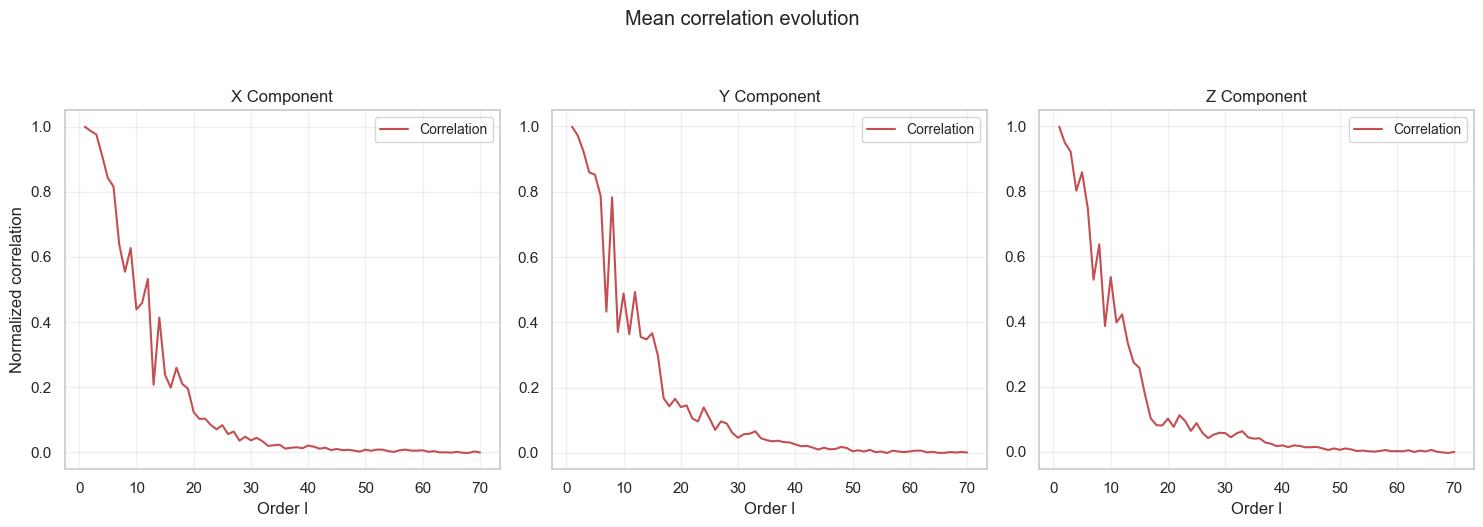

In [57]:
# Calculate number of pairs
n_subjects = 56
n_pairs = (n_subjects * (n_subjects - 1)) // 2  # 1540 pairs

# Calculate significance thresholds
from scipy.stats import norm


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

def setup_correlation_plot(ax, data, title):
    ax.plot(range(1,lmax+1), data, '-r', label='Correlation')

    ax.set_xlabel('Order l')
    ax.set_ylabel("Normalized correlation" if title == "X Component" else "")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize='small')

# Setup each subplot
setup_correlation_plot(ax1, np.array(mean_correlations).T[0], "X Component")
setup_correlation_plot(ax2, np.array(mean_correlations).T[1], "Y Component")
setup_correlation_plot(ax3, np.array(mean_correlations).T[2], "Z Component")

plt.suptitle("Mean correlation evolution", y=1.05)
plt.tight_layout()
plt.show()

In [60]:
def plot_correlation_heatmap(correlations, l):
    n = n_subjects
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    coords = ['x', 'y', 'z']
    titles = ['X Component', 'Y Component', 'Z Component']
    
    # Ajouter un titre global
    fig.suptitle('Correlation Matrix', fontsize=16, y=1.05)
    
    for idx, (coord, title) in enumerate(zip(coords, titles)):
        # Créer la matrice pour chaque composante
        matrix = np.ones((n, n))
        k = 0
        c = idx  # 0 pour x, 1 pour y, 2 pour z
        
        # Remplir la matrice
        for i in range(n):
            for j in range(i+1, n):
                matrix[i,j] = correlations[l][k][c]
                matrix[j,i] = correlations[l][k][c]
                k += 1
        
        # Créer le heatmap
        sns.heatmap(matrix, cmap='coolwarm', center=0, ax=axes[idx])
        axes[idx].set_title(f'{title} (l = {l})')
    
    # Ajuster l'espacement entre les subplots
    plt.tight_layout()
    plt.show()

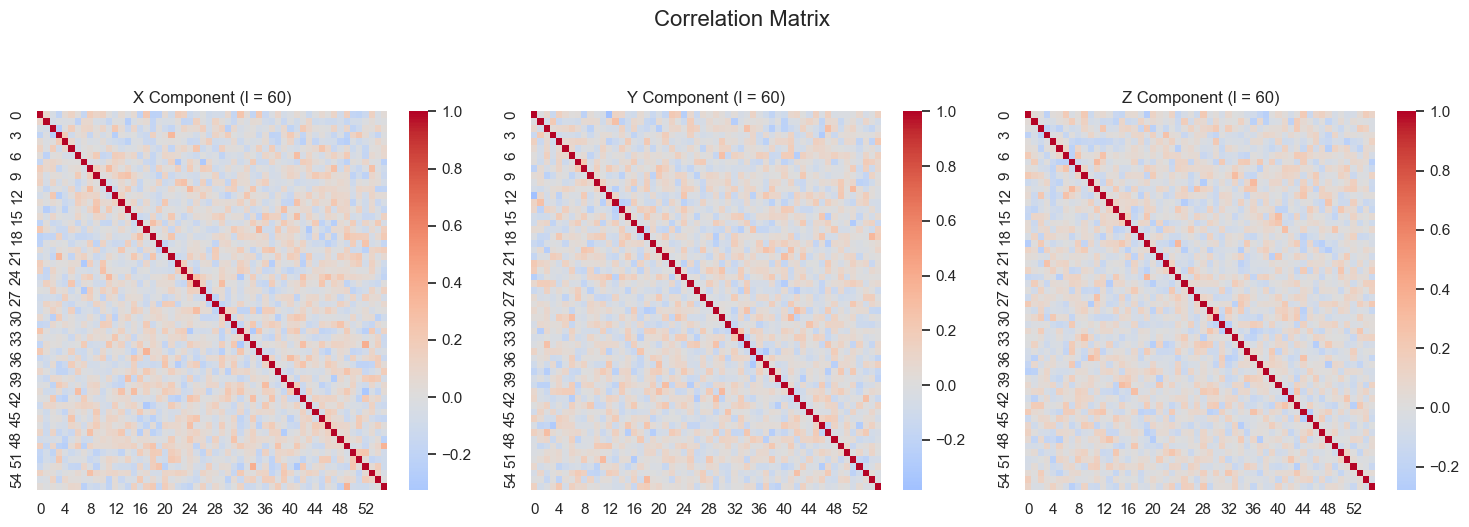

In [66]:
plot_correlation_heatmap(correlations, 60)


l between 23 and 30 seems to give proper results

In [28]:
correlations_3x3 = {l: [] for l in range(lmax+1)}

# Pour chaque participant
for i, participant in enumerate(coeffs_ab):
    # Pour chaque ordre l
    for l in range(lmax+1):
        # Calcul de la matrice 3x3 pour ce participant et ce l
        corr_matrix = np.zeros((3,3))
        for comp1 in range(3):
            for comp2 in range(3):
                corr = correlation_dims_order(
                    (coeffs_ab[participant]['lh'][0], coeffs_ab[participant]['lh'][1]),
                    (coeffs_ab[participant]['lh'][0], coeffs_ab[participant]['lh'][1]),
                    l
                )[comp1,comp2]
                
                # Normalisation avec les puissances
                norm = np.sqrt(powers_lh[l][i][comp1] * powers_lh[l][i][comp2])
                corr_matrix[comp1,comp2] = corr/norm
        
        correlations_3x3[l].append(corr_matrix)

# Pour avoir la moyenne pour chaque l
mean_correlations = {l: np.mean(correlations_3x3[l], axis=0) for l in range(lmax+1)}

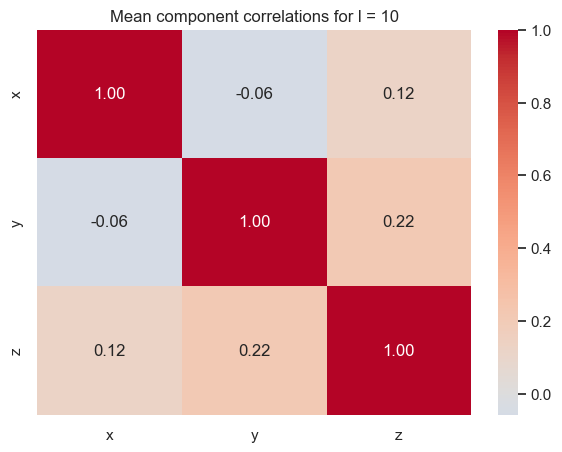

In [29]:
def plot_component_correlation_heatmap(mean_correlations, l):
   plt.figure(figsize=(7, 5))
   sns.heatmap(mean_correlations[l], 
               cmap='coolwarm', 
               center=0,
               annot=True,  # Ajoute les valeurs
               fmt='.2f',   # Format avec 2 décimales
               xticklabels=['x', 'y', 'z'],
               yticklabels=['x', 'y', 'z'])
   plt.title(f'Mean component correlations for l = {l}')
   plt.show()

# Usage:
l = 10
plot_component_correlation_heatmap(mean_correlations, l)

In [19]:
subject_folder = r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\Anatomy_data_CAM_CAN\sub-CC721648"
faces_file=os.path.join(subject_folder, "faces_reduced.mat")
vertices_file=os.path.join(subject_folder, "vertices_reduced.mat")

In [20]:
subject_folder = r"C:\Users\wbou2\Desktop\meg_to_surface_ml\data\Anatomy_data_CAM_CAN\sub-CC721648"
faces_file=os.path.join(subject_folder, "faces_reduced.mat")
vertices_file=os.path.join(subject_folder, "vertices_reduced.mat")
faces = load_faces(faces_file)
vertices = load_vertices(vertices_file)

# Visualisation avec PyVista
mesh = pv.PolyData(vertices, convert_triangles_to_pyvista(faces))
p = pv.Plotter()
p.add_mesh(mesh, show_edges=True, color='white')
p.show()

Widget(value='<iframe src="http://localhost:20349/index.html?ui=P_0x11084c4f0e0_2&reconnect=auto" class="pyvis…

In [18]:
faces.shape, vertices.shape

((29998, 3), (15003, 3))